In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import keras
import keras.utils
from keras import utils as np_utils

import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp

from matplotlib import pyplot as plt
import time

from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
# Get the path to the zip file in your Drive.
zip_file_path = '/content/drive/MyDrive/RevisedData.zip'

# Extract the zip file into the current working directory.
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Print the contents of the current working directory to verify that the files have been extracted.
print(os.listdir())

['.config', 'val', 'drive', 'train', 'sample_data']


In [ ]:
# Get the path to the zip file in your Drive.
zip_file_path = '/content/drive/MyDrive/test.zip'

# Extract the zip file into the current working directory.
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Print the contents of the current working directory to verify that the files have been extracted.
print(os.listdir())

['.config', 'val', 'test', 'drive', 'train', 'sample_data']


#Defining Functions

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

holistic = mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3)

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def extract_keypoints(results):
    #pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [ ]:
def compute_dtw_distance(sequence_a, sequence_b):
    distance, path = fastdtw(sequence_a, sequence_b, dist=euclidean)
    return distance, path

def align_sequences(path, sequence_a, sequence_b):
    aligned_a = []
    aligned_b = []
    for index_a, index_b in path:
        keypoint_a = sequence_a[index_a]
        keypoint_b = sequence_b[index_b]
        aligned_a.append(keypoint_a)
        aligned_b.append(keypoint_b)
    return np.array(aligned_a), np.array(aligned_b)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

#test

In [ ]:
# Set the path to the specific video file that needs to be processed
video_file_path = "/content/Thesis Dataset/data_new_v2/train/104/6.avi"
npy_file_path = "/content/drive/MyDrive/TestFrames/train/104/6"

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Process the specific video file
    video = cv2.VideoCapture(video_file_path)
    frames = []
    frame_num = 0

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        if results.left_hand_landmarks or results.right_hand_landmarks:
            frames.append(frame)
        frame_num += 1

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    video.release()

    # Exception handling for resampling frames
    try:
        frames = np.array(frames)
        num_frames = len(frames)
        if num_frames >= 30:
            indices = np.linspace(0, num_frames - 1, 30, dtype=int)
            resampled_frames = frames[indices]

            for i, frame in enumerate(resampled_frames):
                image, results = mediapipe_detection(frame, holistic)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(npy_file_path, str(i))
                os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                np.save(npy_path, keypoints)
        else:
            raise ValueError(f"Not enough frames to resample: {video_file_path}")
    except ValueError as e:
        print(e)
        # Skip resampling for this video

# Print a success message
print(f"Video file {video_file_path} has been processed and saved to {npy_file_path}.")

Video file /content/Thesis Dataset/data_new_v2/train/104/6.avi has been processed and saved to /content/drive/MyDrive/TestFrames/train/104/6.


#Processing Dataset 30 frames guided with check and skip

In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp

train_dataset_path = "/content/train"
NPY_PATH = '/content/drive/MyDrive/ProcessedNew/train/'

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(train_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(train_dataset_path, subfolder)):
            # Define the npy file path for the current video
            action = subfolder
            sequence = int(video_file.split('.')[0])
            npy_file_path = os.path.join(NPY_PATH, action, str(sequence))

            # Check if the npy file path already exists
            if os.path.exists(npy_file_path):
                #print(f"Skipping already processed video: {npy_file_path}")
                continue  # Skip the current video

            # Process the video file
            video_path = os.path.join(train_dataset_path, subfolder, video_file)
            video = cv2.VideoCapture(video_path)
            frames = []
            frame_num = 0

            while video.isOpened():
                ret, frame = video.read()
                if not ret:
                    break
                image, results = mediapipe_detection(frame, holistic)
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    frames.append(frame)
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            video.release()

            # Exception handling for resampling frames
            try:
                frames = np.array(frames)
                num_frames = len(frames)
                if num_frames >= 30:
                    indices = np.linspace(0, num_frames - 1, 30, dtype=int)
                    resampled_frames = frames[indices]

                    for i, frame in enumerate(resampled_frames):
                        image, results = mediapipe_detection(frame, holistic)
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(npy_file_path, str(i))
                        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                        np.save(npy_path, keypoints)
                else:
                    raise ValueError(f"Not enough frames to resample: {npy_file_path}")
            except ValueError as e:
                print(e)
                continue  # Skip resampling for this video
    video.release()

Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/9/8
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/9/6
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/9/0
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/62/1
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/3/5
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/38/2
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/29/7
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/21/8
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/21/1
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/21/4
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/21/6
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/train/21/7
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/t

In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp

train_dataset_path = "/content/val"
NPY_PATH = '/content/drive/MyDrive/ProcessedNew/val/'

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(train_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(train_dataset_path, subfolder)):
            # Define the npy file path for the current video
            action = subfolder
            sequence = int(video_file.split('.')[0])
            npy_file_path = os.path.join(NPY_PATH, action, str(sequence))

            # Check if the npy file path already exists
            if os.path.exists(npy_file_path):
                #print(f"Skipping already processed video: {npy_file_path}")
                continue  # Skip the current video

            # Process the video file
            video_path = os.path.join(train_dataset_path, subfolder, video_file)
            video = cv2.VideoCapture(video_path)
            frames = []
            frame_num = 0

            while video.isOpened():
                ret, frame = video.read()
                if not ret:
                    break
                image, results = mediapipe_detection(frame, holistic)
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    frames.append(frame)
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            video.release()

            # Exception handling for resampling frames
            try:
                frames = np.array(frames)
                num_frames = len(frames)
                if num_frames >= 30:
                    indices = np.linspace(0, num_frames - 1, 30, dtype=int)
                    resampled_frames = frames[indices]

                    for i, frame in enumerate(resampled_frames):
                        image, results = mediapipe_detection(frame, holistic)
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(npy_file_path, str(i))
                        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                        np.save(npy_path, keypoints)
                else:
                    raise ValueError(f"Not enough frames to resample: {npy_file_path}")
            except ValueError as e:
                print(e)
                continue  # Skip resampling for this video
    video.release()

Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/val/23/0
Not enough frames to resample: /content/drive/MyDrive/ProcessedNew/val/21/0


In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp

train_dataset_path = "/content/newtestvideos/test"
NPY_PATH = '/content/drive/MyDrive/ProcessedTestNew/test/'

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(train_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(train_dataset_path, subfolder)):
            # Define the npy file path for the current video
            action = subfolder
            sequence = int(video_file.split('.')[0])
            npy_file_path = os.path.join(NPY_PATH, action, str(sequence))

            # Check if the npy file path already exists
            if os.path.exists(npy_file_path):
                #print(f"Skipping already processed video: {npy_file_path}")
                continue  # Skip the current video

            # Process the video file
            video_path = os.path.join(train_dataset_path, subfolder, video_file)
            video = cv2.VideoCapture(video_path)
            frames = []
            frame_num = 0

            while video.isOpened():
                ret, frame = video.read()
                if not ret:
                    break
                image, results = mediapipe_detection(frame, holistic)
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    frames.append(frame)
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            video.release()

            # Exception handling for resampling frames
            try:
                frames = np.array(frames)
                num_frames = len(frames)
                if num_frames >= 30:
                    indices = np.linspace(0, num_frames - 1, 30, dtype=int)
                    resampled_frames = frames[indices]

                    for i, frame in enumerate(resampled_frames):
                        image, results = mediapipe_detection(frame, holistic)
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(npy_file_path, str(i))
                        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                        np.save(npy_path, keypoints)
                else:
                    raise ValueError(f"Not enough frames to resample: {npy_file_path}")
            except ValueError as e:
                print(e)
                continue  # Skip resampling for this video
    video.release()

Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/71/3
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/71/0
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/58/3
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/58/2
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/53/1
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/53/3
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/53/2
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/38/1
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/116/1
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/116/0
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/116/2
Not enough frames to resample: /content/drive/MyDrive/ProcessedTestNew/test/49/1
Not enough frames to resa

# Process Dataset 30 frames Guided

In [ ]:
train_dataset_path = "/content/Thesis Dataset/data_new_v2/train"

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(train_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(train_dataset_path, subfolder)):
            # Get the path to the video file
            video_path = os.path.join(train_dataset_path, subfolder, video_file)
            # Open the video file
            video = cv2.VideoCapture(video_path)
            # Get the action name from the subfolder name
            action = subfolder
            # Get the sequence number from the video file name
            sequence = int(video_file.split('.')[0])
            # Create a frame counter
            frame_num = 0
            # Create a list to store the frames
            frames = []

            # Loop over the frames of the video until the end of the video
            while video.isOpened():
                # Read a frame
                ret, frame = video.read()
                # Check if the frame is valid
                if not ret:
                    # Break the loop if the frame is invalid
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Check if hand landmarks exist on the frame
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    # Append the frame to the list
                    frames.append(frame)
                else:
                    # Skip the frame if no hand landmarks are detected
                    continue

                # Increment the frame counter
                frame_num += 1

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            if len(frames) > 0:
              # Resample 30 frames from the list
              frames = np.array(frames)
              num_frames = len(frames)
              indices = np.linspace(0, num_frames - 1, 30, dtype=int)
              resampled_frames = frames[indices]

            # NEW Loop over the resampled frames
            for i, frame in enumerate(resampled_frames):
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                # Define a new variable for the npy file path
                NPY_PATH = '/content/drive/MyDrive/normalizednpwithhand/train/'
                # Save the npy file in the new directory
                npy_path = os.path.join(NPY_PATH, action, str(sequence), str(i))
                # Create the directory if it does not exist
                os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                # Save the npy file
                np.save(npy_path, keypoints)

    video.release()

In [ ]:
val_dataset_path = "/content/Thesis Dataset/data_new_v2/val"

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(val_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(val_dataset_path, subfolder)):
            # Get the path to the video file
            video_path = os.path.join(val_dataset_path, subfolder, video_file)
            # Open the video file
            video = cv2.VideoCapture(video_path)
            # Get the action name from the subfolder name
            action = subfolder
            # Get the sequence number from the video file name
            sequence = int(video_file.split('.')[0])
            # Create a frame counter
            frame_num = 0
            # Create a list to store the frames
            frames = []

            # Loop over the frames of the video until the end of the video
            while video.isOpened():
                # Read a frame
                ret, frame = video.read()
                # Check if the frame is valid
                if not ret:
                    # Break the loop if the frame is invalid
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Check if hand landmarks exist on the frame
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    # Append the frame to the list
                    frames.append(frame)
                else:
                    # Skip the frame if no hand landmarks are detected
                    continue

                # Increment the frame counter
                frame_num += 1

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # NEW Resample 30 frames from the list
            frames = np.array(frames)
            num_frames = len(frames)
            indices = np.linspace(0, num_frames - 1, 30, dtype=int)
            resampled_frames = frames[indices]

            # NEW Loop over the resampled frames
            for i, frame in enumerate(resampled_frames):
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                # Define a new variable for the npy file path
                NPY_PATH = '/content/drive/MyDrive/Processed/val/'
                # Save the npy file in the new directory
                npy_path = os.path.join(NPY_PATH, action, str(sequence), str(i))
                # Create the directory if it does not exist
                os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                # Save the npy file
                np.save(npy_path, keypoints)

    video.release()

In [ ]:
test_dataset_path = "/content/Thesis Dataset/data_new_v2/test"

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop over the subfolders in the dataset path
    for subfolder in os.listdir(test_dataset_path):
        # Loop over the video files in the subfolder
        for video_file in os.listdir(os.path.join(test_dataset_path, subfolder)):
            # Get the path to the video file
            video_path = os.path.join(test_dataset_path, subfolder, video_file)
            # Open the video file
            video = cv2.VideoCapture(video_path)
            # Get the action name from the subfolder name
            action = subfolder
            # Get the sequence number from the video file name
            sequence = int(video_file.split('.')[0])
            # Create a frame counter
            frame_num = 0
            # Create a list to store the frames
            frames = []

            # Loop over the frames of the video until the end of the video
            while video.isOpened():
                # Read a frame
                ret, frame = video.read()
                # Check if the frame is valid
                if not ret:
                    # Break the loop if the frame is invalid
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Check if hand landmarks exist on the frame
                if results.left_hand_landmarks or results.right_hand_landmarks:
                    # Append the frame to the list
                    frames.append(frame)
                else:
                    # Skip the frame if no hand landmarks are detected
                    continue

                # Increment the frame counter
                frame_num += 1

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # NEW Resample 30 frames from the list
            frames = np.array(frames)
            num_frames = len(frames)
            indices = np.linspace(0, num_frames - 1, 30, dtype=int)
            resampled_frames = frames[indices]

            # NEW Loop over the resampled frames
            for i, frame in enumerate(resampled_frames):
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                # Define a new variable for the npy file path
                NPY_PATH = '/content/drive/MyDrive/Processed/test/'
                # Save the npy file in the new directory
                npy_path = os.path.join(NPY_PATH, action, str(sequence), str(i))
                # Create the directory if it does not exist
                os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                # Save the npy file
                np.save(npy_path, keypoints)

    video.release()

#NPY array

In [ ]:
NPY_PATH = '/content/train'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

train_sequences_guided = np.array(sequences)
train_labels_guided = np.array(labels)

In [ ]:
NPY_PATH = '/content/val'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

val_sequences_guided = np.array(sequences)
val_labels_guided = np.array(labels)

In [ ]:
NPY_PATH = '/content/test'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

test_sequences_guided = np.array(sequences)
test_labels_guided = np.array(labels)

In [ ]:
np.save("/content/drive/MyDrive/train_sequences_guided.npy", train_sequences_guided)
np.save("/content/drive/MyDrive/train_labels_guided.npy", train_labels_guided)
np.save("/content/drive/MyDrive/val_sequences_guided.npy", val_sequences_guided)
np.save("/content/drive/MyDrive/val_labels_guided.npy", val_labels_guided)

In [ ]:
np.save("/content/drive/MyDrive/test_sequences_guided.npy", test_sequences_guided)
np.save("/content/drive/MyDrive/test_labels_guided.npy", test_labels_guided)

#NEW NPY array

In [ ]:
NPY_PATH = '/content/New stuff fr fr/train'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

train_sequences_guided_new = np.array(sequences)
train_labels_guided_new = np.array(labels)

In [ ]:
NPY_PATH = '/content/New stuff fr fr/val'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

val_sequences_guided_new = np.array(sequences)
val_labels_guided_new = np.array(labels)

In [ ]:
NPY_PATH = '/content/test'

actions = os.listdir(NPY_PATH)
sequence_length = 30
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(NPY_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(NPY_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(action)

test_sequences_guided = np.array(sequences)
test_labels_guided = np.array(labels)

In [ ]:
np.save("/content/drive/MyDrive/train_sequences_guided.npy", train_sequences_guided)
np.save("/content/drive/MyDrive/train_labels_guided.npy", train_labels_guided)
np.save("/content/drive/MyDrive/val_sequences_guided.npy", val_sequences_guided)
np.save("/content/drive/MyDrive/val_labels_guided.npy", val_labels_guided)

In [ ]:
np.save("/content/drive/MyDrive/test_sequences_guided.npy", test_sequences_guided)
np.save("/content/drive/MyDrive/test_labels_guided.npy", test_labels_guided)

In [ ]:
np.save("/content/drive/MyDrive/train_sequences_guided_new.npy", train_sequences_guided_new)
np.save("/content/drive/MyDrive/train_labels_guided_new.npy", train_labels_guided_new)
np.save("/content/drive/MyDrive/val_sequences_guided_new.npy", val_sequences_guided_new)
np.save("/content/drive/MyDrive/val_labels_guided_new.npy", val_labels_guided_new)

#Check Shape etc

In [ ]:
train_sequences_guided = np.load('/content/drive/MyDrive/train_sequences_guided.npy')
train_labels_guided = np.load("/content/drive/MyDrive/train_labels_guided.npy")
val_sequences_guided = np.load("/content/drive/MyDrive/val_sequences_guided.npy")
val_labels_guided = np.load("/content/drive/MyDrive/val_labels_guided.npy")
test_sequences_guided = np.load("/content/drive/MyDrive/test_sequences_guided.npy")
test_labels_guided = np.load("/content/drive/MyDrive/test_labels_guided.npy")

In [ ]:
print(train_sequences_guided)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.98998857e-01
    4.23718512e-01 -2.59670801e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.09069002e-01
    4.05638605e-01 -1.70481168e-02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.26856726e-01
    4.21213090e-01 -1.95332319e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.27257866e-01
    4.20734853e-01 -1.85485911e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.39596802e-01
    4.51508582e-01 -2.61348467e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.52492207e-01
    4.89504635e-01 -2.39506755e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.49113667e-01
    4.52844471e-01 -1.03392312e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.48615253e-01
    4.51650858e-01 -1.07829189e-02]
  ...
  [ 0.00000000e+00  0.0

In [ ]:
train_sequences_guided.shape

(4770, 30, 126)

In [ ]:
train_labels_guided.shape

(4770,)

In [ ]:
val_sequences_guided.shape

(2120, 30, 126)

In [ ]:
val_labels_guided.shape

(2120,)

In [ ]:
test_labels_guided.shape

(2120,)

In [ ]:
train_labels_guided = keras.utils.to_categorical(train_labels_guided, num_classes=530)
val_labels_guided = keras.utils.to_categorical(val_labels_guided, num_classes=530)

In [ ]:
train_labels_guided.shape

(4770, 530)

In [ ]:
val_labels_guided.shape

(2120, 530)

In [ ]:
test_labels_guided = keras.utils.to_categorical(test_labels_guided, num_classes=530)

In [ ]:
test_labels_guided.shape

(2120, 530)

In [ ]:
test_sequences_guided.shape

(2120, 30, 126)

In [ ]:
#actions=np.array(actions)
#actions.shape

In [ ]:
#np.save("actionsnew.npy", actions)

#New Check Shape etc

In [ ]:
train_sequences_guided_new = np.load('/content/drive/MyDrive/train_sequences_guided_new.npy')
train_labels_guided_new = np.load("/content/drive/MyDrive/train_labels_guided_new.npy")
val_sequences_guided_new = np.load("/content/drive/MyDrive/val_sequences_guided_new.npy")
val_labels_guided_new = np.load("/content/drive/MyDrive/val_labels_guided_new.npy")

In [ ]:
print(train_sequences_guided_new)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.99062961e-01
    5.43138385e-01  7.95957167e-04]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.10329193e-01
    5.11934519e-01 -5.36004221e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.12253648e-01
    5.06525517e-01  3.75078549e-03]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.20258254e-01
    6.63614690e-01 -1.29023939e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.19302464e-01
    6.93392634e-01 -2.25237990e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.94510984e-01
    7.71144390e-01 -2.66021658e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.52861404e-01
    5.67977011e-01 -8.77041928e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.62660617e-01
    5.58964550e-01 -2.09530373e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.63700867e-01
    5.73437154e-01  1.49479648e-03]
  ...
  [ 0.00000000e+00  0.0

In [ ]:
train_sequences_guided_new.shape

(405, 30, 126)

In [ ]:
train_labels_guided_new.shape

(405,)

In [ ]:
val_sequences_guided_new.shape

(180, 30, 126)

In [ ]:
val_labels_guided_new.shape

(180,)

In [ ]:
train_labels_guided_new = keras.utils.to_categorical(train_labels_guided_new, num_classes=45)
val_labels_guided_new = keras.utils.to_categorical(val_labels_guided_new, num_classes=45)

In [ ]:
train_labels_guided_new.shape

(405, 45)

In [ ]:
val_labels_guided_new.shape

(180, 45)

In [ ]:
test_labels_guided = keras.utils.to_categorical(test_labels_guided, num_classes=530)

In [ ]:
test_labels_guided.shape

(2120, 530)

In [ ]:
test_sequences_guided.shape

(2120, 30, 126)

In [ ]:
actions=np.array(actions)
actions.shape

(45,)

In [ ]:
np.save("actionsnew.npy", actions)

#Model Architecture old

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2


modelg1 = Sequential()
modelg1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
modelg1.add(LSTM(128, return_sequences=True, activation='relu'))
modelg1.add(LSTM(64, return_sequences=False, activation='relu'))
modelg1.add(Dense(64, activation='relu'))
modelg1.add(Dropout(0.5))
modelg1.add(Dense(64, activation='relu'))
modelg1.add(Dense(32, activation='relu'))
modelg1.add(Dense(actions.shape[0], activation='softmax'))


modelg1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


modelg1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)               

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

# Model architecture
modelg2 = Sequential([
    # LSTM layer(s), you might want to experiment with the number of units and adding more LSTM layers
    LSTM(64, return_sequences=True, input_shape=(30, 126)),
    LSTM(32),
    # Dense layer(s), you might adjust the number of neurons
    Dense(64, activation='relu'),
    Dense(530, activation='softmax')  # Output layer with 530 units for 530 classes
])

# Compile the model
modelg2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to understand its structure
modelg2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 530)               34450     
                                                                 
Total params: 97874 (382.32 KB)
Trainable params: 97874 (382.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Model architecture with dropout and L2 regularization
modelg3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126), dropout=0.5),
    LSTM(32, dropout=0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(530, activation='softmax')
])

modelg3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelg3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 30, 64)            48896     
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 530)               34450     
                                                                 
Total params: 97874 (382.32 KB)
Trainable params: 97874 (382.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

modelg4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126),
         dropout=0.5, recurrent_dropout=0.5,
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4),
         bias_regularizer=regularizers.l2(1e-4),
         activity_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LSTM(32, dropout=0.5, recurrent_dropout=0.5,
         kernel_constraint=MaxNorm(max_value=2)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(530, activation='softmax')
])

modelg4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelg4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 64)            48896     
                                                                 
 batch_normalization (Batch  (None, 30, 64)            256       
 Normalization)                                                  
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model5 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126),
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LSTM(32, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(530, activation='softmax')
])

model5.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            48896     
                                                                 
 batch_normalization (Batch  (None, 30, 64)            256       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 530)               3

#Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2


modelg1_new = Sequential()
modelg1_new.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
modelg1_new.add(LSTM(128, return_sequences=True, activation='relu'))
modelg1_new.add(LSTM(64, return_sequences=False, activation='relu'))
modelg1_new.add(Dense(64, activation='relu'))
modelg1_new.add(Dropout(0.5))
modelg1_new.add(Dense(64, activation='relu'))
modelg1_new.add(Dense(32, activation='relu'))
modelg1_new.add(Dense(actions.shape[0], activation='softmax'))


modelg1_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


modelg1_new.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_8 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history1_new = modelg1_new.fit(
    train_sequences_guided_new,
    train_labels_guided_new,
    validation_data=(val_sequences_guided_new, val_labels_guided_new),
    epochs=200,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/200
13/13 - 7s - loss: 3.8068 - categorical_accuracy: 0.0198 - val_loss: 3.7994 - val_categorical_accuracy: 0.0222 - 7s/epoch - 543ms/step
Epoch 2/200
13/13 - 1s - loss: 3.7948 - categorical_accuracy: 0.0346 - val_loss: 3.7512 - val_categorical_accuracy: 0.0444 - 1s/epoch - 96ms/step
Epoch 3/200
13/13 - 1s - loss: 3.7615 - categorical_accuracy: 0.0395 - val_loss: 3.7200 - val_categorical_accuracy: 0.0667 - 1s/epoch - 84ms/step
Epoch 4/200
13/13 - 1s - loss: 3.6700 - categorical_accuracy: 0.0444 - val_loss: 3.5726 - val_categorical_accuracy: 0.0722 - 1s/epoch - 83ms/step
Epoch 5/200
13/13 - 1s - loss: 3.6140 - categorical_accuracy: 0.0568 - val_loss: 3.5605 - val_categorical_accuracy: 0.0889 - 1s/epoch - 84ms/step
Epoch 6/200
13/13 - 2s - loss: 3.5288 - categorical_accuracy: 0.0691 - val_loss: 3.4661 - val_categorical_accuracy: 0.0722 - 2s/epoch - 128ms/step
Epoch 7/200
13/13 - 2s - loss: 3.4406 - categorical_accuracy: 0.0617 - val_loss: 3.3943 - val_categorical_accuracy: 0.1167

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model5_new = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126),
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LSTM(32, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(45, activation='softmax')
])

model5_new.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model5_new.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            48896     
                                                                 
 batch_normalization_2 (Bat  (None, 30, 64)            256       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dense_15 (Dense)            (None, 45)               

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history5_new = model5_new.fit(
    train_sequences_guided_new, train_labels_guided_new,
    validation_data=(val_sequences_guided_new, val_labels_guided_new),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
13/13 [==============================] - 8s 202ms/step - loss: 3.7070 - accuracy: 0.0667 - val_loss: 3.8099 - val_accuracy: 0.0444 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 60ms/step - loss: 3.1655 - accuracy: 0.2395 - val_loss: 3.7725 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 1s 42ms/step - loss: 2.8205 - accuracy: 0.3605 - val_loss: 3.7329 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 1s 49ms/step - loss: 2.4999 - accuracy: 0.4222 - val_loss: 3.6850 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 1s 42ms/step - loss: 2.2364 - accuracy: 0.5062 - val_loss: 3.5981 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 41ms/step - loss: 1.9116 - accuracy: 0.5951 - val_loss: 3.5237 - val_accuracy: 0.1778 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 1s 43ms/step - l

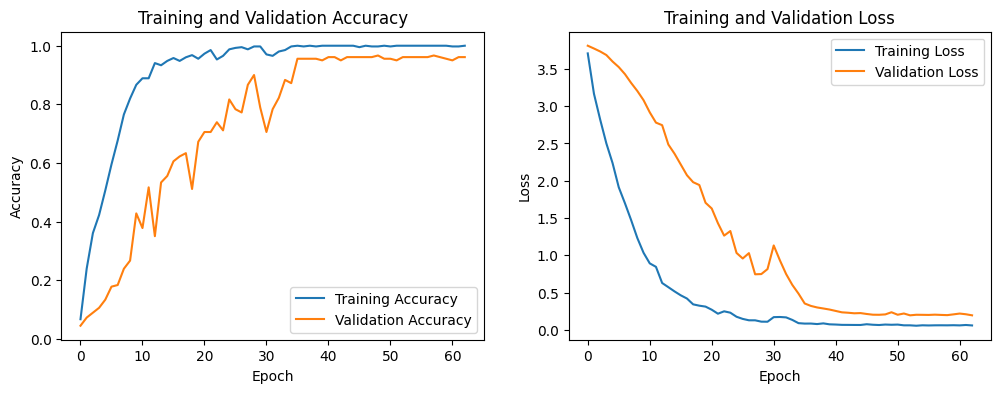

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history5_new.history['accuracy'], label='Training Accuracy')
plt.plot(history5_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history5_new.history['loss'], label='Training Loss')
plt.plot(history5_new.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model5.png', format='png')

plt.show()

In [ ]:
model5_new.save('/content/drive/MyDrive/Model5_newfinal.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model5_new.save_weights('/content/drive/MyDrive/Model5_newWeights.h5')

#Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history1 = modelg1.fit(
    train_sequences_guided,
    train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/200
150/150 - 20s - loss: 6.2076 - categorical_accuracy: 0.0015 - val_loss: 5.9749 - val_categorical_accuracy: 0.0047 - 20s/epoch - 130ms/step
Epoch 2/200
150/150 - 13s - loss: 5.8300 - categorical_accuracy: 0.0021 - val_loss: 5.6620 - val_categorical_accuracy: 0.0047 - 13s/epoch - 84ms/step
Epoch 3/200
150/150 - 12s - loss: 5.6529 - categorical_accuracy: 0.0036 - val_loss: 5.5895 - val_categorical_accuracy: 0.0038 - 12s/epoch - 83ms/step
Epoch 4/200
150/150 - 12s - loss: 5.5788 - categorical_accuracy: 0.0023 - val_loss: 5.4783 - val_categorical_accuracy: 0.0038 - 12s/epoch - 78ms/step
Epoch 5/200
150/150 - 13s - loss: 5.4807 - categorical_accuracy: 0.0029 - val_loss: 5.3934 - val_categorical_accuracy: 0.0038 - 13s/epoch - 84ms/step
Epoch 6/200
150/150 - 12s - loss: 5.3695 - categorical_accuracy: 0.0048 - val_loss: 5.2517 - val_categorical_accuracy: 0.0127 - 12s/epoch - 80ms/step
Epoch 7/200
150/150 - 12s - loss: 5.1576 - categorical_accuracy: 0.0067 - val_loss: 5.0152 - val_ca

In [ ]:
history2 = modelg2.fit(
    train_sequences_guided,
    train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/200
150/150 - 12s - loss: 6.0931 - accuracy: 0.0021 - val_loss: 5.6831 - val_accuracy: 0.0113 - 12s/epoch - 79ms/step
Epoch 2/200
150/150 - 4s - loss: 5.4352 - accuracy: 0.0048 - val_loss: 5.0475 - val_accuracy: 0.0184 - 4s/epoch - 30ms/step
Epoch 3/200
150/150 - 7s - loss: 4.8621 - accuracy: 0.0172 - val_loss: 4.6025 - val_accuracy: 0.0377 - 7s/epoch - 49ms/step
Epoch 4/200
150/150 - 5s - loss: 4.3749 - accuracy: 0.0384 - val_loss: 4.1633 - val_accuracy: 0.0608 - 5s/epoch - 34ms/step
Epoch 5/200
150/150 - 5s - loss: 3.8957 - accuracy: 0.0713 - val_loss: 3.7413 - val_accuracy: 0.0958 - 5s/epoch - 34ms/step
Epoch 6/200
150/150 - 6s - loss: 3.5017 - accuracy: 0.1048 - val_loss: 3.6014 - val_accuracy: 0.1222 - 6s/epoch - 41ms/step
Epoch 7/200
150/150 - 5s - loss: 3.2105 - accuracy: 0.1484 - val_loss: 3.3074 - val_accuracy: 0.1443 - 5s/epoch - 34ms/step
Epoch 8/200
150/150 - 7s - loss: 2.9448 - accuracy: 0.1788 - val_loss: 3.0073 - val_accuracy: 0.2165 - 7s/epoch - 44ms/step
Epoch 

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = modelg3.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 13s 58ms/step - loss: 6.1501 - accuracy: 0.0029 - val_loss: 5.7579 - val_accuracy: 0.0038 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 5s 37ms/step - loss: 5.7381 - accuracy: 0.0040 - val_loss: 5.5306 - val_accuracy: 0.0085 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 7s 46ms/step - loss: 5.5322 - accuracy: 0.0057 - val_loss: 5.3087 - val_accuracy: 0.0066 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 6s 40ms/step - loss: 5.3548 - accuracy: 0.0080 - val_loss: 5.0998 - val_accuracy: 0.0222 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 7s 47ms/step - loss: 5.1501 - accuracy: 0.0109 - val_loss: 4.8330 - val_accuracy: 0.0222 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 6s 41ms/step - loss: 4.9501 - accuracy: 0.0166 - val_loss: 4.5828 - val_accuracy: 0.0491 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 6s

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = modelg4.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 34s 123ms/step - loss: 6.2370 - accuracy: 0.0048 - val_loss: 5.9686 - val_accuracy: 0.0137 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 14s 90ms/step - loss: 5.6447 - accuracy: 0.0065 - val_loss: 5.2312 - val_accuracy: 0.0245 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 13s 87ms/step - loss: 5.2011 - accuracy: 0.0170 - val_loss: 4.6591 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 14s 90ms/step - loss: 4.8737 - accuracy: 0.0229 - val_loss: 4.3751 - val_accuracy: 0.0660 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 13s 88ms/step - loss: 4.6596 - accuracy: 0.0346 - val_loss: 4.1567 - val_accuracy: 0.0887 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 14s 90ms/step - loss: 4.4812 - accuracy: 0.0386 - val_loss: 4.0194 - val_accuracy: 0.0948 - lr: 0.0010
Epoch 7/200
150/150 [==============================

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history5 = model5.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 14s 50ms/step - loss: 5.7777 - accuracy: 0.0149 - val_loss: 5.7814 - val_accuracy: 0.0250 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 7s 44ms/step - loss: 4.3945 - accuracy: 0.0541 - val_loss: 4.3365 - val_accuracy: 0.0868 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 5s 35ms/step - loss: 3.6269 - accuracy: 0.1256 - val_loss: 3.5227 - val_accuracy: 0.1599 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 7s 46ms/step - loss: 3.1387 - accuracy: 0.1857 - val_loss: 3.0744 - val_accuracy: 0.2524 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 5s 35ms/step - loss: 2.6971 - accuracy: 0.2717 - val_loss: 2.8017 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 7s 48ms/step - loss: 2.2669 - accuracy: 0.3832 - val_loss: 2.5040 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 5s

#Accuracy plot

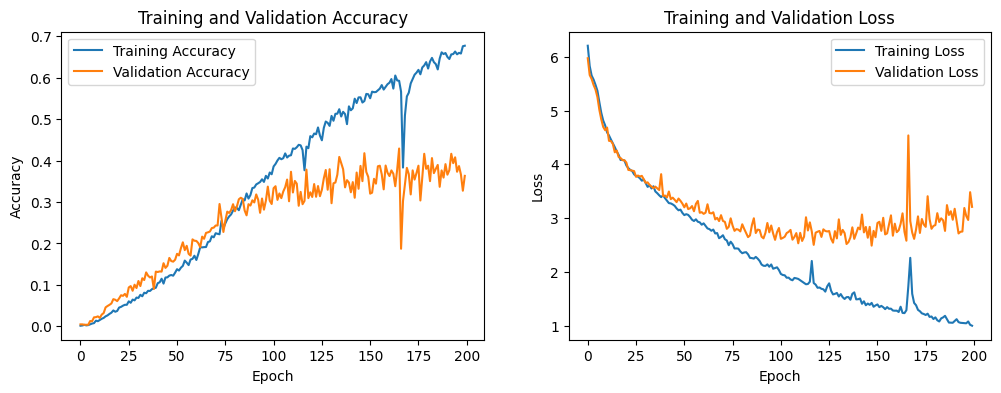

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

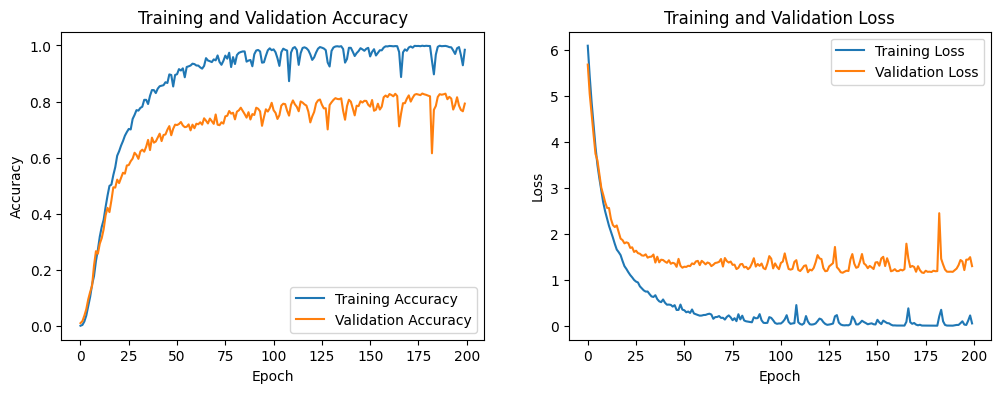

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

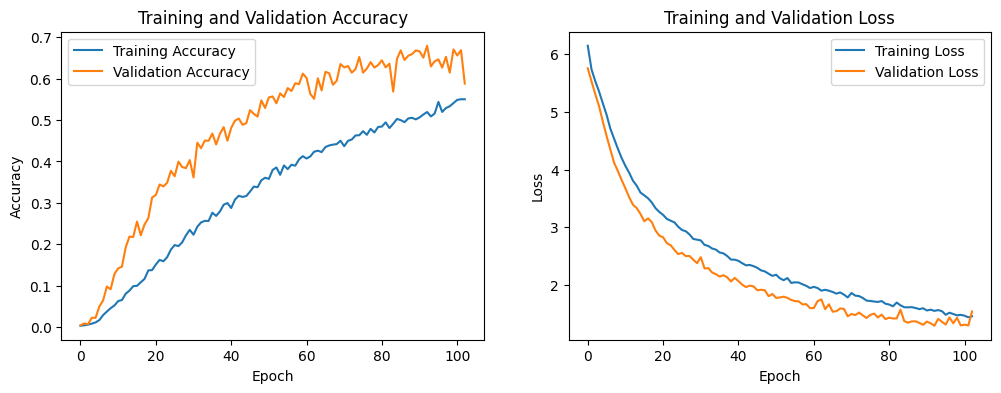

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

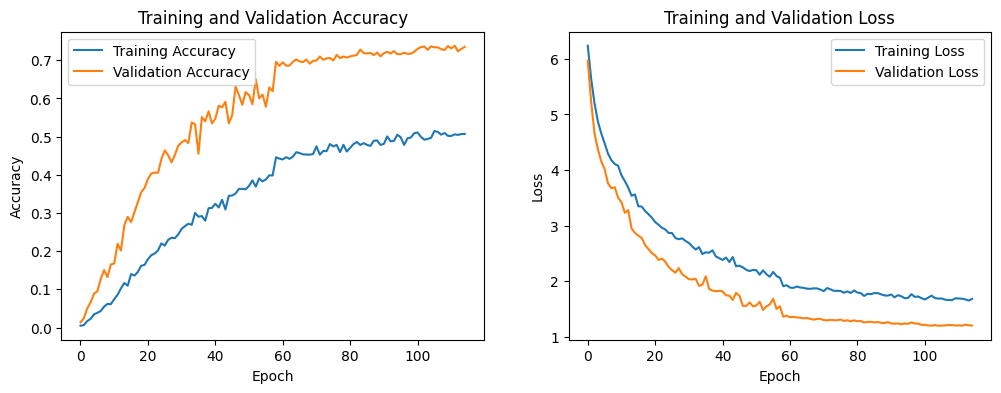

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

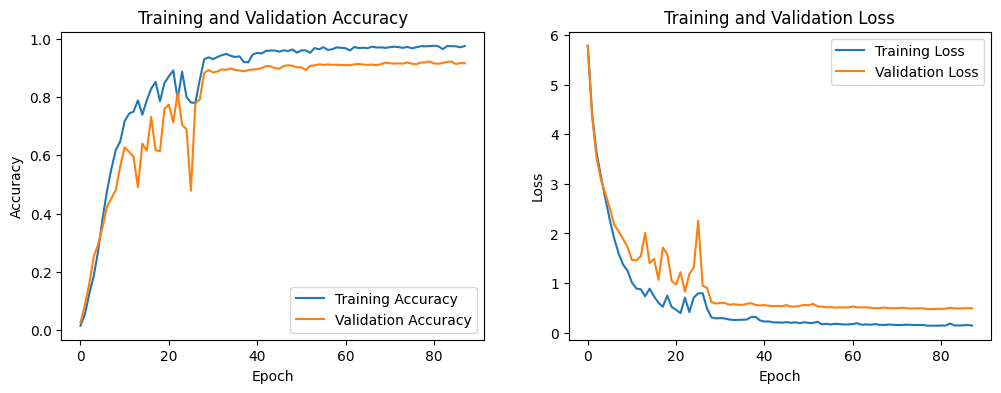

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model5.png', format='png')

plt.show()

#Save and export

In [ ]:
model5.save('Model5final.keras')

In [ ]:
model5.save('/content/drive/MyDrive/Model5final.keras')

In [ ]:
model5.save('/content/drive/MyDrive/Model5final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model5.save_weights('/content/drive/MyDrive/Model5Weights.h5')

In [ ]:
model.load_weights('path_to_my_weights.h5')

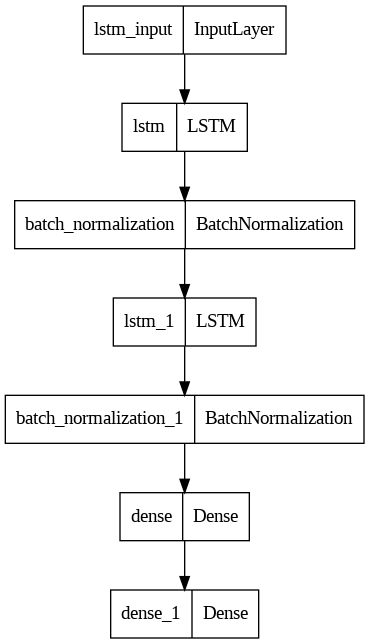

In [ ]:
from keras.utils import plot_model
plot_model(model5, to_file='my_model5.png')

#load and test

In [ ]:
!cat /content/drive/MyDrive/Pleasework.h5

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import tensorflow as tf

modeltest = tf.keras.models.load_model('/content/drive/MyDrive/Model5final.h5')

In [ ]:
test_sequences_guided.shape

(2120, 30, 126)

In [ ]:
test_labels_guided.shape

(2120, 530)

In [ ]:
modeltest.evaluate(test_sequences_guided, test_labels_guided)

67/67 [==============================] - 2s 14ms/step - loss: 1.0461 - accuracy: 0.8472


[1.0461266040802002, 0.847169816493988]

In [ ]:
# prompt: write the code to get precision, F1 score, accuracy of model

import numpy as np
from sklearn.metrics import precision_score, f1_score, accuracy_score

# Get model predictions
y_pred = modeltest.predict(test_sequences_guided)

# Convert predictions to class indices
y_pred = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = np.argmax(test_labels_guided, axis=1)

# Calculate metrics
precision = precision_score(y_true, y_pred, average="micro")
f1 = f1_score(y_true, y_pred, average="micro")
accuracy = accuracy_score(y_true, y_pred)

# Print results
print("Precision:", precision)
print("F1 Score:", f1)
print("Accuracy:", accuracy)


67/67 [==============================] - 2s 14ms/step
Precision: 0.8471698113207548
F1 Score: 0.8471698113207549
Accuracy: 0.8471698113207548


In [ ]:
val_labels_guided.shape

(2120, 530, 530)

In [ ]:
val_sequences_guided.shape

(2120, 30, 126)

In [ ]:
# prompt: write the code to get precision, F1 score, accuracy of model

import numpy as np
from sklearn.metrics import precision_score, f1_score, accuracy_score

# Get model predictions
y_pred = modeltest.predict(val_sequences_guided)

# Convert predictions to class indices
y_pred = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = np.argmax(val_labels_guided, axis=1)

# Calculate metrics
precision = precision_score(y_true, y_pred, average="micro")
f1 = f1_score(y_true, y_pred, average="micro")
accuracy = accuracy_score(y_true, y_pred)

# Print results
print("Precision:", precision)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

67/67 [==============================] - 1s 16ms/step
Precision: 0.9183962264150943
F1 Score: 0.9183962264150943
Accuracy: 0.9183962264150943


In [ ]:
# prompt: write the code to get the confusion matrix of a model

from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test data
predictions = modeltest.predict(test_sequences_guided)

# Get the indices of the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the indices of the true classes
true_classes = np.argmax(test_labels_guided, axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

print(cm)

67/67 [==============================] - 3s 20ms/step
[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


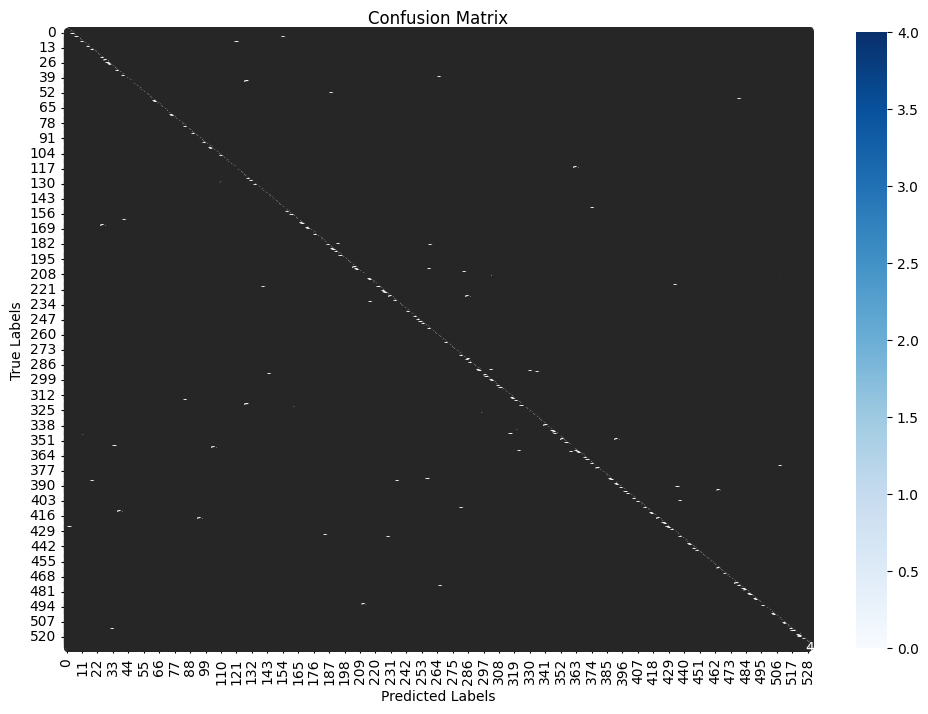

In [ ]:
# prompt: plot confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

# Make predictions on the test data
predictions = modeltest.predict(test_sequences_guided)

# Get the indices of the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the indices of the true classes
true_classes = np.argmax(test_labels_guided, axis=1)

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_classes, predicted_classes)

# Print the metrics for each class
for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
    print(f"Class {i}: Precision = {p:.3f}, Recall = {r:.3f}, F1-Score = {f1:.3f}")

67/67 [==============================] - 1s 18ms/step
Class 0: Precision = 0.800, Recall = 1.000, F1-Score = 0.889
Class 1: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 2: Precision = 0.800, Recall = 1.000, F1-Score = 0.889
Class 3: Precision = 0.667, Recall = 1.000, F1-Score = 0.800
Class 4: Precision = 0.800, Recall = 1.000, F1-Score = 0.889
Class 5: Precision = 0.750, Recall = 0.750, F1-Score = 0.750
Class 6: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 7: Precision = 1.000, Recall = 0.250, F1-Score = 0.400
Class 8: Precision = 1.000, Recall = 0.500, F1-Score = 0.667
Class 9: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 10: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 11: Precision = 0.000, Recall = 0.000, F1-Score = 0.000
Class 12: Precision = 1.000, Recall = 0.500, F1-Score = 0.667
Class 13: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 14: Precision = 1.000, Recall = 1.000, F1-Score = 1.000
Class 15: Precision = 1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

# Mask to zero-out the diagonal (correct classifications)
np.fill_diagonal(cm, 0)

# Find the most significant misclassifications
# Flatten the matrix, sort it, and get the indices of the top misclassifications
num_misclassifications_to_report = 10  # Adjust based on how many you want to report
misclassified_indices = np.dstack(np.unravel_index(np.argsort(cm.ravel())[-num_misclassifications_to_report:], cm.shape))[0]

print("Most common misclassifications:")
for idx in misclassified_indices:
    actual_class, predicted_class = idx
    count = cm[actual_class, predicted_class]
    print(f"Actual class {actual_class} predicted as class {predicted_class}: {count} times")

Most common misclassifications:
Actual class 350 predicted as class 11: 4 times
Actual class 515 predicted as class 514: 4 times
Actual class 133 predicted as class 109: 4 times
Actual class 326 predicted as class 161: 4 times
Actual class 214 predicted as class 507: 4 times
Actual class 213 predicted as class 302: 4 times
Actual class 346 predicted as class 320: 4 times
Actual class 11 predicted as class 198: 4 times
Actual class 521 predicted as class 522: 4 times
Actual class 86 predicted as class 438: 4 times


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming true_classes and predicted_classes are defined

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Mask the diagonal (correct classifications) to focus on misclassifications
np.fill_diagonal(cm, 0)

# Iterate through the confusion matrix to find misclassifications
misclassifications = []
for actual_class in range(cm.shape[0]):
    for predicted_class in range(cm.shape[1]):
        if cm[actual_class, predicted_class] > 0:
            misclassifications.append((actual_class, predicted_class, cm[actual_class, predicted_class]))

# Sort misclassifications by frequency (optional)
misclassifications_sorted = sorted(misclassifications, key=lambda x: x[2], reverse=True)

print("Misclassified classes and their counts:")
for actual_class, predicted_class, count in misclassifications_sorted:
    print(f"Actual class {actual_class} predicted as class {predicted_class}: {count} times")


Misclassified classes and their counts:
Actual class 11 predicted as class 198: 4 times
Actual class 86 predicted as class 438: 4 times
Actual class 133 predicted as class 109: 4 times
Actual class 213 predicted as class 302: 4 times
Actual class 214 predicted as class 507: 4 times
Actual class 326 predicted as class 161: 4 times
Actual class 331 predicted as class 295: 4 times
Actual class 346 predicted as class 320: 4 times
Actual class 350 predicted as class 11: 4 times
Actual class 515 predicted as class 514: 4 times
Actual class 521 predicted as class 522: 4 times
Actual class 155 predicted as class 375: 3 times
Actual class 165 predicted as class 42: 3 times
Actual class 210 predicted as class 284: 3 times
Actual class 221 predicted as class 434: 3 times
Actual class 236 predicted as class 217: 3 times
Actual class 285 predicted as class 287: 3 times
Actual class 296 predicted as class 336: 3 times
Actual class 320 predicted as class 85: 3 times
Actual class 377 predicted as clas

#After Corrections

In [ ]:
#model training

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model_new_1 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126),
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LSTM(32, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(530, activation='softmax')
])

model_new_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_new_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            48896     
                                                                 
 batch_normalization (Batch  (None, 30, 64)            256       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 530)               3

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_new_1 = model_new_1.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 13s 49ms/step - loss: 5.7912 - accuracy: 0.0155 - val_loss: 5.7288 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 5s 36ms/step - loss: 4.4270 - accuracy: 0.0568 - val_loss: 4.3695 - val_accuracy: 0.0816 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 6s 38ms/step - loss: 3.6399 - accuracy: 0.1306 - val_loss: 3.5787 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 8s 51ms/step - loss: 2.9934 - accuracy: 0.2449 - val_loss: 2.9963 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 5s 34ms/step - loss: 2.3283 - accuracy: 0.3906 - val_loss: 2.6287 - val_accuracy: 0.3302 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 7s 45ms/step - loss: 2.0073 - accuracy: 0.4497 - val_loss: 2.1653 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 5s

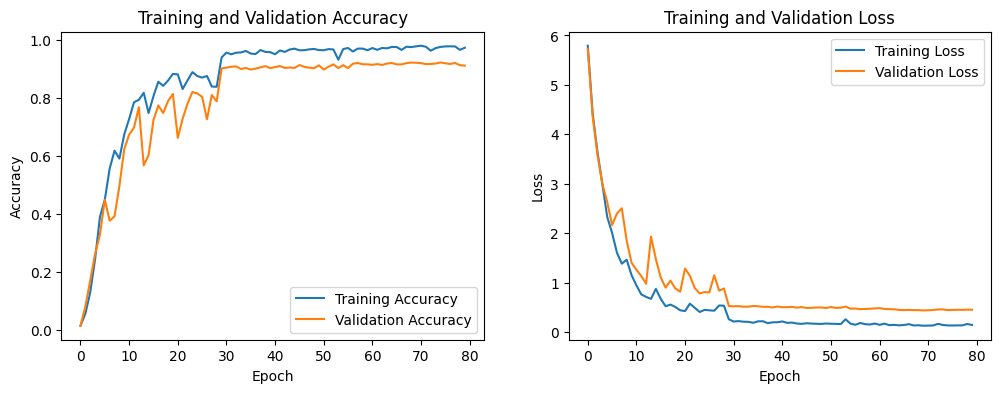

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_new_1.history['loss'], label='Training Loss')
plt.plot(history_new_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_new.png', format='png')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

# Evaluate on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_1, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_1, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_1, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 13ms/step
Training Data - Accuracy: 0.9951781970649896, Precision: 0.9956969288573062, Recall: 0.9951781970649896, F1 Score: 0.9951332645661347
67/67 [==============================] - 1s 14ms/step
Validation Data - Accuracy: 0.9216981132075471, Precision: 0.9368598382749325, Recall: 0.9216981132075471, F1 Score: 0.9154813635002313
67/67 [==============================] - 1s 15ms/step
Test Data - Accuracy: 0.8495283018867924, Precision: 0.8751572327044025, Recall: 0.8495283018867924, F1 Score: 0.8358860217350782


In [ ]:
from tensorflow.keras.layers import Dropout

model_new_2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 126),
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),  # Adding dropout
    BatchNormalization(),
    LSTM(32, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),  # Adding dropout
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),  # Adding dropout
    Dense(530, activation='softmax')
])

model_new_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_new_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            48896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 30, 64)            256       
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

In [ ]:
# Updated callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_new_2 = model_new_2.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 18s 81ms/step - loss: 6.1583 - accuracy: 0.0031 - val_loss: 5.8257 - val_accuracy: 0.0142 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 11s 73ms/step - loss: 5.4355 - accuracy: 0.0073 - val_loss: 5.0468 - val_accuracy: 0.0283 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 11s 76ms/step - loss: 4.9418 - accuracy: 0.0222 - val_loss: 4.5806 - val_accuracy: 0.0443 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 12s 78ms/step - loss: 4.5815 - accuracy: 0.0289 - val_loss: 4.1383 - val_accuracy: 0.0830 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 12s 79ms/step - loss: 4.3395 - accuracy: 0.0361 - val_loss: 3.8773 - val_accuracy: 0.0887 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 10s 68ms/step - loss: 4.1956 - accuracy: 0.0514 - val_loss: 3.7375 - val_accuracy: 0.1085 - lr: 0.0010
Epoch 7/200
150/150 [==============================]

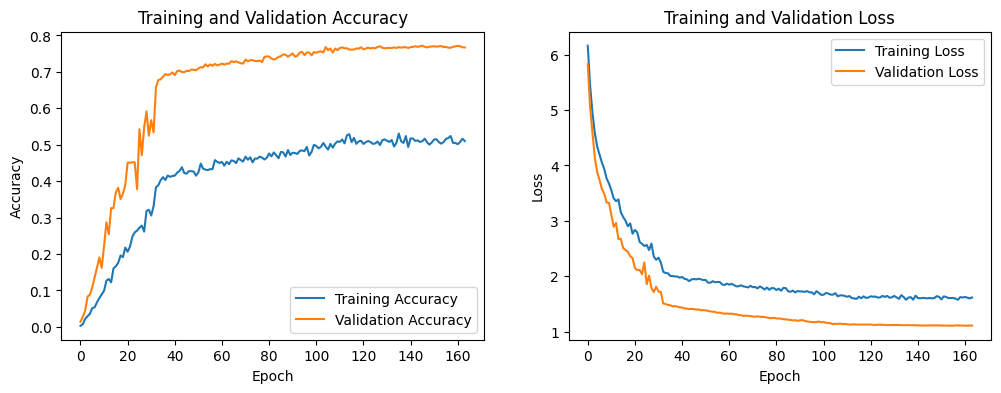

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_new_2.history['loss'], label='Training Loss')
plt.plot(history_new_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_new_2.png', format='png')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

# Evaluate on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_2, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_2, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_2, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 15ms/step
Training Data - Accuracy: 0.9060796645702306, Precision: 0.9196314263489623, Recall: 0.9060796645702306, F1 Score: 0.9000438816015115
67/67 [==============================] - 1s 10ms/step
Validation Data - Accuracy: 0.7683962264150943, Precision: 0.8151762231479213, Recall: 0.7683962264150943, F1 Score: 0.7417909815551326
67/67 [==============================] - 1s 10ms/step
Test Data - Accuracy: 0.6811320754716981, Precision: 0.7403594728123031, Recall: 0.6811320754716981, F1 Score: 0.646752174327091


In [ ]:
from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_new_3 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30, 126),
         kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(20, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(530, activation='softmax')
])

model_new_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_new_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            35400     
                                                                 
 dropout_3 (Dropout)         (None, 30, 50)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 30, 50)            200       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 20)                5680      
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 batch_normalization_5 (Bat  (None, 20)                80        
 chNormalization)                                     

In [ ]:
history_new_3 = model_new_3.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 15s 65ms/step - loss: 6.2589 - accuracy: 0.0027 - val_loss: 6.0457 - val_accuracy: 0.0038 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 12s 81ms/step - loss: 5.8470 - accuracy: 0.0063 - val_loss: 5.5326 - val_accuracy: 0.0080 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 11s 74ms/step - loss: 5.5084 - accuracy: 0.0105 - val_loss: 5.1572 - val_accuracy: 0.0175 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 5s 33ms/step - loss: 5.2637 - accuracy: 0.0115 - val_loss: 4.9811 - val_accuracy: 0.0165 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 6s 40ms/step - loss: 5.0656 - accuracy: 0.0136 - val_loss: 4.7557 - val_accuracy: 0.0358 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 6s 39ms/step - loss: 4.8974 - accuracy: 0.0176 - val_loss: 4.5260 - val_accuracy: 0.0505 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 

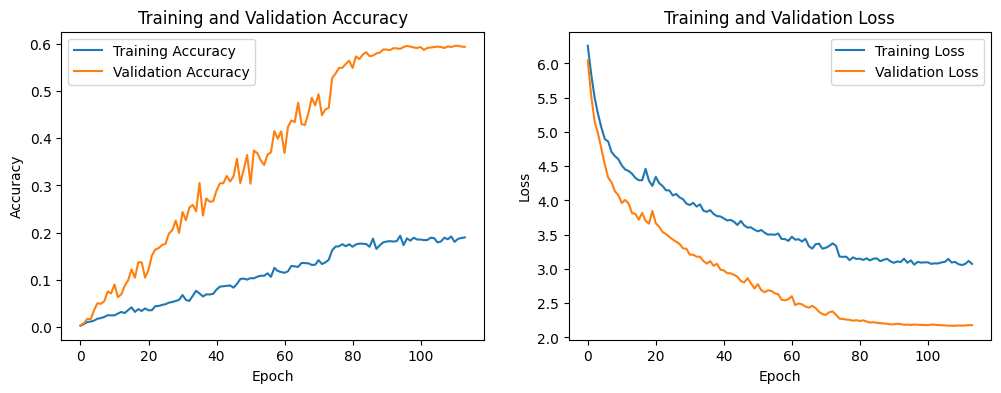

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_new_3.history['loss'], label='Training Loss')
plt.plot(history_new_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_new_3.png', format='png')

plt.show()

In [ ]:
from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_new_4 = Sequential([
    LSTM(100, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.3),  # Reduced dropout
    BatchNormalization(),
    LSTM(50, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    BatchNormalization(),
    Dense(100, activation='relu'),
    Dense(530, activation='softmax')
])

model_new_4.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_new_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 batch_normalization_2 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 batch_normalization_3 (Bat  (None, 50)                200       
 chNormalization)                                     

In [ ]:
history_new_4 = model_new_4.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 19s 69ms/step - loss: 5.7856 - accuracy: 0.0069 - val_loss: 5.3160 - val_accuracy: 0.0193 - lr: 0.0015
Epoch 2/200
150/150 [==============================] - 10s 69ms/step - loss: 4.5331 - accuracy: 0.0371 - val_loss: 4.5769 - val_accuracy: 0.0340 - lr: 0.0015
Epoch 3/200
150/150 [==============================] - 9s 63ms/step - loss: 3.9868 - accuracy: 0.0675 - val_loss: 3.7142 - val_accuracy: 0.1000 - lr: 0.0015
Epoch 4/200
150/150 [==============================] - 23s 151ms/step - loss: 3.5318 - accuracy: 0.1027 - val_loss: 3.3433 - val_accuracy: 0.1547 - lr: 0.0015
Epoch 5/200
150/150 [==============================] - 19s 128ms/step - loss: 3.1376 - accuracy: 0.1558 - val_loss: 3.1850 - val_accuracy: 0.1594 - lr: 0.0015
Epoch 6/200
150/150 [==============================] - 19s 125ms/step - loss: 2.9735 - accuracy: 0.1761 - val_loss: 2.6792 - val_accuracy: 0.2632 - lr: 0.0015
Epoch 7/200
150/150 [=============================

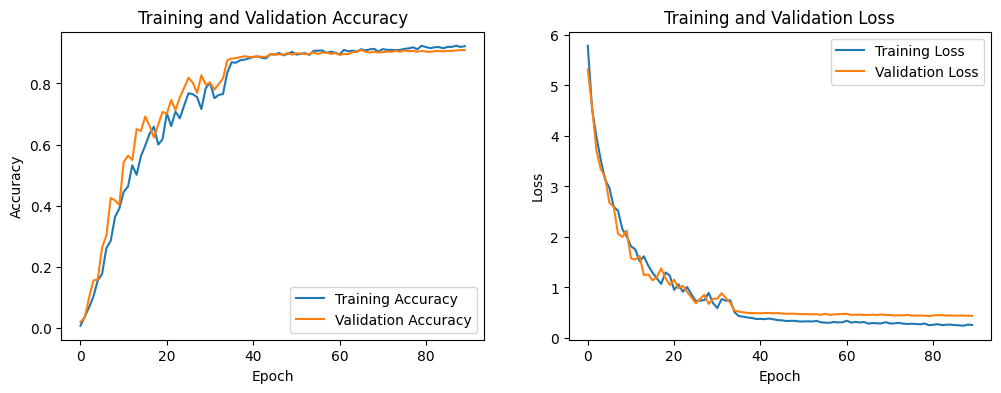

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_new_4.history['loss'], label='Training Loss')
plt.plot(history_new_4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_new_4.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_4, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_4, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_4, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 17ms/step
Training Data - Accuracy: 0.9924528301886792, Precision: 0.9938443396226414, Recall: 0.9924528301886792, F1 Score: 0.9919760792102343
67/67 [==============================] - 2s 27ms/step
Validation Data - Accuracy: 0.9066037735849056, Precision: 0.9234755914944593, Recall: 0.9066037735849056, F1 Score: 0.8978695204166902
67/67 [==============================] - 2s 28ms/step
Test Data - Accuracy: 0.839622641509434, Precision: 0.8713690764162462, Recall: 0.839622641509434, F1 Score: 0.8224824016777402


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def build_model(hp):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50),
                   input_shape=(30, 126),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(530, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_lstm_tuning'
)

tuner.search(train_sequences_guided, train_labels_guided,
             epochs=50,
             validation_data=(val_sequences_guided, val_labels_guided))


Trial 5 Complete [00h 30m 49s]
val_accuracy: 0.7072327136993408

Best val_accuracy So Far: 0.7072327136993408
Total elapsed time: 03h 29m 27s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
150               |100               |units
0.3               |0.2               |dropout_1
0.3               |0.2               |dropout_2
0.001             |0.001             |learning_rate

Epoch 1/50
150/150 [==============================] - 28s 163ms/step - loss: 6.0635 - accuracy: 0.0023 - val_loss: 5.7501 - val_accuracy: 0.0061
Epoch 2/50
150/150 [==============================] - 23s 156ms/step - loss: 5.6721 - accuracy: 0.0048 - val_loss: 5.4089 - val_accuracy: 0.0118
Epoch 3/50
150/150 [==============================] - 20s 133ms/step - loss: 5.3161 - accuracy: 0.0128 - val_loss: 4.9445 - val_accuracy: 0.0410
Epoch 4/50
150/150 [==============================] - 25s 165ms/step - loss: 4.8583 - accuracy: 0.0323 - val_loss: 4.5489 - val_accuracy: 0.0585
Epoch

In [ ]:
model_new_4.save('/content/drive/MyDrive/Model_new_4.keras')
model_new_1.save('/content/drive/MyDrive/Model_new_1.keras')

In [ ]:
import keras_tuner as kt

def build_model(hp):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50),
                   input_shape=(30, 126),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=50, max_value=150, step=50)))
    model.add(Dense(530, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir_2',
    project_name='keras_lstm_tuning_2'
)

tuner.search(train_sequences_guided, train_labels_guided,
             epochs=50,
             validation_data=(val_sequences_guided, val_labels_guided))

In [ ]:
model_tuned_1 = Sequential([
    LSTM(100, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    LSTM(100, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    Dense(530, activation='softmax')
])

model_tuned_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_tuned_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 530)               53530     
                                                                 
Total params: 224730 (877.85 KB)
Trainable params: 224730 (877.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_tuned_1 = model_tuned_1.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 36s 200ms/step - loss: 6.0627 - accuracy: 0.0019 - val_loss: 5.7791 - val_accuracy: 0.0038 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 21s 139ms/step - loss: 5.7651 - accuracy: 0.0040 - val_loss: 5.5834 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 12s 80ms/step - loss: 5.5383 - accuracy: 0.0069 - val_loss: 5.3237 - val_accuracy: 0.0179 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 11s 71ms/step - loss: 5.3242 - accuracy: 0.0117 - val_loss: 5.1456 - val_accuracy: 0.0241 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 11s 71ms/step - loss: 5.0939 - accuracy: 0.0226 - val_loss: 4.8951 - val_accuracy: 0.0458 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 12s 78ms/step - loss: 4.8269 - accuracy: 0.0331 - val_loss: 4.6357 - val_accuracy: 0.0547 - lr: 0.0010
Epoch 7/200
150/150 [=============================

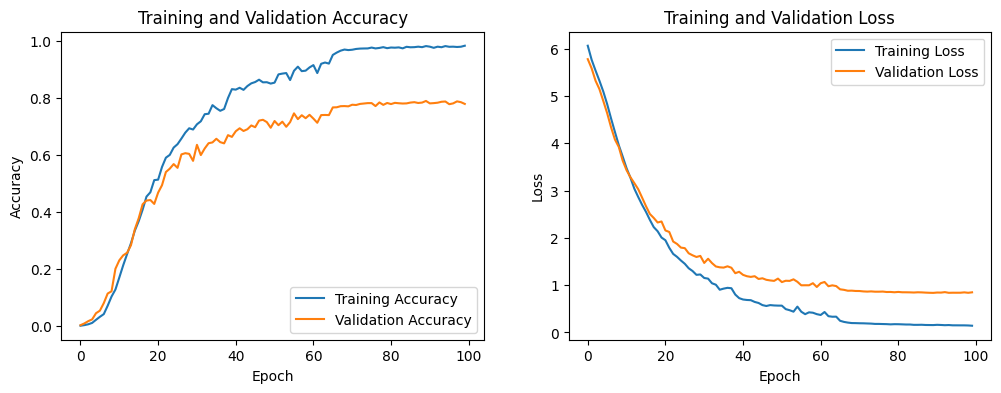

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tuned_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_tuned_1.history['loss'], label='Training Loss')
plt.plot(history_tuned_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_tuned_1.png', format='png')

plt.show()

In [ ]:
model_tuned_2 = Sequential([
    LSTM(150, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.3),  # Reduced dropout
    LSTM(150, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.3),  # Reduced dropout
    Dense(530, activation='softmax')
])

model_tuned_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_tuned_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 150)           166200    
                                                                 
 dropout_4 (Dropout)         (None, 30, 150)           0         
                                                                 
 lstm_8 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_5 (Dropout)         (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 530)               80030     
                                                                 
Total params: 426830 (1.63 MB)
Trainable params: 426830 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_tuned_2 = model_tuned_2.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 25s 142ms/step - loss: 6.0583 - accuracy: 0.0023 - val_loss: 5.7453 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 22s 143ms/step - loss: 5.6463 - accuracy: 0.0050 - val_loss: 5.3852 - val_accuracy: 0.0108 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 20s 132ms/step - loss: 5.3036 - accuracy: 0.0130 - val_loss: 4.9929 - val_accuracy: 0.0292 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 23s 152ms/step - loss: 4.9005 - accuracy: 0.0237 - val_loss: 4.6351 - val_accuracy: 0.0519 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 22s 149ms/step - loss: 4.5324 - accuracy: 0.0438 - val_loss: 4.3168 - val_accuracy: 0.0854 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 22s 150ms/step - loss: 4.2174 - accuracy: 0.0683 - val_loss: 3.9870 - val_accuracy: 0.1137 - lr: 0.0010
Epoch 7/200
150/150 [=========================

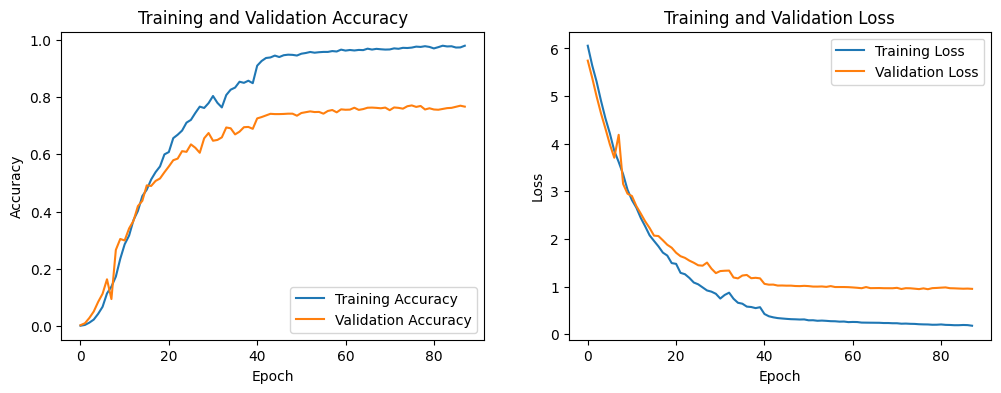

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tuned_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_tuned_2.history['loss'], label='Training Loss')
plt.plot(history_tuned_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_tuned_2.png', format='png')

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_model(hp):
    model = Sequential([
        LSTM(units=hp.Int('units1', min_value=50, max_value=150, step=25),
             return_sequences=True,
             input_shape=(30, 126),
             kernel_regularizer=regularizers.l2(1e-5)),
        Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)),
        BatchNormalization(),
        LSTM(units=hp.Int('units2', min_value=30, max_value=100, step=10),
             kernel_regularizer=regularizers.l2(1e-5)),
        Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)),
        BatchNormalization(),
        Dense(100, activation='relu'),
        Dense(530, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start search
tuner.search(train_sequences_guided, train_labels_guided,
             epochs=50,
             validation_data=(val_sequences_guided, val_labels_guided),
             callbacks=[reduce_lr, early_stopping])

Trial 20 Complete [00h 14m 19s]
val_accuracy: 0.8879716992378235

Best val_accuracy So Far: 0.9221698343753815
Total elapsed time: 06h 49m 20s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           90800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 batch_normalization (Batch  (None, 30, 100)           400       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 70)                47880     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 70)                280       
 chNormalization)                                       

In [ ]:
# Optionally, you can also fetch the best hyperparameters like this:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print('Best hyperparameters:', best_hyperparameters.values)

Best hyperparameters: {'units1': 100, 'dropout1': 0.2, 'units2': 70, 'dropout2': 0.2, 'learning_rate': 0.000602836972293706}


In [ ]:
history_best_model = best_model.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 35s 188ms/step - loss: 0.3109 - accuracy: 0.9069 - val_loss: 0.4153 - val_accuracy: 0.9226 - lr: 1.0000e-04
Epoch 2/200
150/150 [==============================] - 17s 111ms/step - loss: 0.3077 - accuracy: 0.9113 - val_loss: 0.4163 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 3/200
150/150 [==============================] - 13s 89ms/step - loss: 0.2806 - accuracy: 0.9182 - val_loss: 0.4096 - val_accuracy: 0.9231 - lr: 1.0000e-04
Epoch 4/200
150/150 [==============================] - 10s 68ms/step - loss: 0.2798 - accuracy: 0.9210 - val_loss: 0.4111 - val_accuracy: 0.9184 - lr: 1.0000e-04
Epoch 5/200
150/150 [==============================] - 10s 64ms/step - loss: 0.2870 - accuracy: 0.9176 - val_loss: 0.3925 - val_accuracy: 0.9292 - lr: 1.0000e-04
Epoch 6/200
150/150 [==============================] - 11s 73ms/step - loss: 0.2705 - accuracy: 0.9264 - val_loss: 0.3981 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 7/200
150/150 [=====

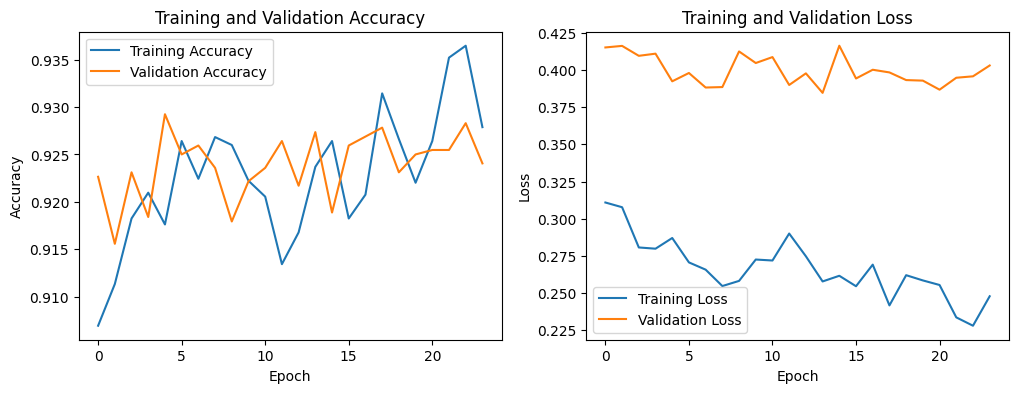

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_best_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_best_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_best_model.history['loss'], label='Training Loss')
plt.plot(history_best_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_best_model.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_4, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_4, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_4, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 7s 40ms/step
Training Data - Accuracy: 0.9924528301886792, Precision: 0.9938443396226414, Recall: 0.9924528301886792, F1 Score: 0.9919760792102343
67/67 [==============================] - 1s 17ms/step
Validation Data - Accuracy: 0.9066037735849056, Precision: 0.9234755914944593, Recall: 0.9066037735849056, F1 Score: 0.8978695204166902
67/67 [==============================] - 1s 17ms/step
Test Data - Accuracy: 0.839622641509434, Precision: 0.8713690764162462, Recall: 0.839622641509434, F1 Score: 0.8224824016777402


In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_1, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_1, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_1, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 18ms/step
Training Data - Accuracy: 0.9951781970649896, Precision: 0.9956969288573062, Recall: 0.9951781970649896, F1 Score: 0.9951332645661347
67/67 [==============================] - 1s 17ms/step
Validation Data - Accuracy: 0.9216981132075471, Precision: 0.9368598382749325, Recall: 0.9216981132075471, F1 Score: 0.9154813635002313
67/67 [==============================] - 1s 19ms/step
Test Data - Accuracy: 0.8495283018867924, Precision: 0.8751572327044025, Recall: 0.8495283018867924, F1 Score: 0.8358860217350782


In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(best_model, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(best_model, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(best_model, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 6s 30ms/step
Training Data - Accuracy: 0.9916142557651991, Precision: 0.9931623015349431, Recall: 0.9916142557651991, F1 Score: 0.9908671129190143
67/67 [==============================] - 1s 18ms/step
Validation Data - Accuracy: 0.9273584905660377, Precision: 0.9416801437556155, Recall: 0.9273584905660377, F1 Score: 0.919136649514008
67/67 [==============================] - 1s 18ms/step
Test Data - Accuracy: 0.8566037735849057, Precision: 0.8811106346483705, Recall: 0.8566037735849057, F1 Score: 0.8407970122121066


In [ ]:
best_model.save('/content/drive/MyDrive/best_model.keras')

In [ ]:
from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_new_5_tuned = Sequential([
    LSTM(100, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    BatchNormalization(),
    LSTM(70, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    BatchNormalization(),
    Dense(100, activation='relu'),
    Dense(530, activation='softmax')
])

model_new_5_tuned.compile(optimizer=Adam(learning_rate=0.000603), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_new_5_tuned.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout_8 (Dropout)         (None, 30, 100)           0         
                                                                 
 batch_normalization_8 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 lstm_9 (LSTM)               (None, 70)                47880     
                                                                 
 dropout_9 (Dropout)         (None, 70)                0         
                                                                 
 batch_normalization_9 (Bat  (None, 70)                280       
 chNormalization)                                     

In [ ]:
history_model_new_5_tuned = model_new_5_tuned.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 36s 142ms/step - loss: 5.9399 - accuracy: 0.0103 - val_loss: 5.7665 - val_accuracy: 0.0127 - lr: 6.0300e-04
Epoch 2/200
150/150 [==============================] - 13s 88ms/step - loss: 4.8996 - accuracy: 0.0298 - val_loss: 4.7126 - val_accuracy: 0.0458 - lr: 6.0300e-04
Epoch 3/200
150/150 [==============================] - 9s 62ms/step - loss: 4.1841 - accuracy: 0.0660 - val_loss: 4.0890 - val_accuracy: 0.0821 - lr: 6.0300e-04
Epoch 4/200
150/150 [==============================] - 10s 67ms/step - loss: 3.6904 - accuracy: 0.1140 - val_loss: 3.3660 - val_accuracy: 0.2241 - lr: 6.0300e-04
Epoch 5/200
150/150 [==============================] - 11s 71ms/step - loss: 3.2243 - accuracy: 0.1996 - val_loss: 3.3239 - val_accuracy: 0.1967 - lr: 6.0300e-04
Epoch 6/200
150/150 [==============================] - 9s 61ms/step - loss: 2.9519 - accuracy: 0.2358 - val_loss: 2.9178 - val_accuracy: 0.2561 - lr: 6.0300e-04
Epoch 7/200
150/150 [========

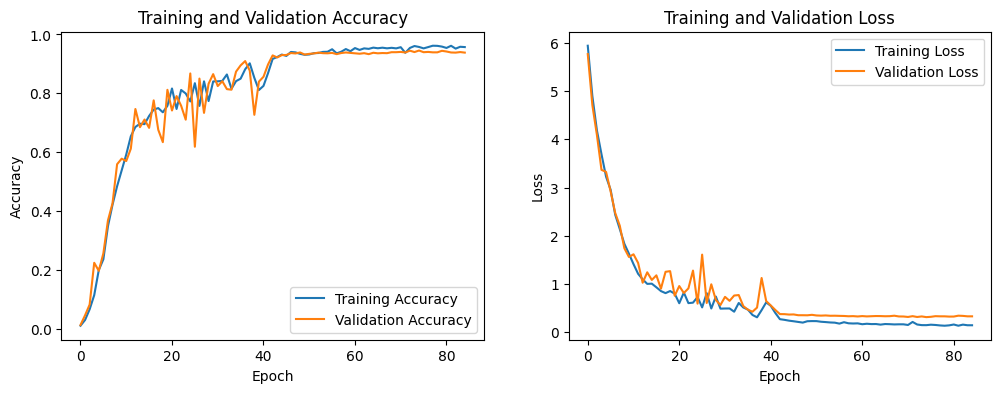

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_new_5_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_new_5_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_new_5_tuned.history['loss'], label='Training Loss')
plt.plot(history_model_new_5_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_new_5_tuned.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_5_tuned, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_5_tuned, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_5_tuned, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 7s 29ms/step
Training Data - Accuracy: 0.9955974842767296, Precision: 0.9958519153802174, Recall: 0.9955974842767297, F1 Score: 0.9954697231424843
67/67 [==============================] - 1s 20ms/step
Validation Data - Accuracy: 0.9452830188679245, Precision: 0.9560961365678345, Recall: 0.9452830188679245, F1 Score: 0.9413089112145716
67/67 [==============================] - 1s 18ms/step
Test Data - Accuracy: 0.8839622641509434, Precision: 0.9084141958670261, Recall: 0.8839622641509434, F1 Score: 0.8711763184404695


In [ ]:
model_new_5_tuned.save('/content/drive/MyDrive/model_new_5_tuned.keras')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model_hybrid = Sequential([
    LSTM(90, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.25),  # A good balance of dropout to prevent overfitting
    BatchNormalization(),
    LSTM(60, return_sequences=False, kernel_regularizer=regularizers.l2(1e-5)),  # Slightly fewer units in the second LSTM
    Dropout(0.25),
    BatchNormalization(),
    Dense(120, activation='relu', kernel_regularizer=regularizers.l1(1e-4)),  # Higher complexity in dense layer
    Dense(530, activation='softmax')
])

model_hybrid.compile(
    optimizer=Adam(learning_rate=0.001),  # Starting with a moderate learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_hybrid.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 30, 90)            78120     
                                                                 
 dropout_14 (Dropout)        (None, 30, 90)            0         
                                                                 
 batch_normalization_30 (Ba  (None, 30, 90)            360       
 tchNormalization)                                               
                                                                 
 lstm_15 (LSTM)              (None, 60)                36240     
                                                                 
 dropout_15 (Dropout)        (None, 60)                0         
                                                                 
 batch_normalization_31 (Ba  (None, 60)                240       
 tchNormalization)                                    

In [ ]:
history_model_hybrid = model_hybrid.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 17s 73ms/step - loss: 5.9258 - accuracy: 0.0078 - val_loss: 5.5799 - val_accuracy: 0.0236 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 11s 71ms/step - loss: 4.7495 - accuracy: 0.0291 - val_loss: 4.6135 - val_accuracy: 0.0495 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 8s 53ms/step - loss: 4.1025 - accuracy: 0.0688 - val_loss: 3.8192 - val_accuracy: 0.1217 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 10s 68ms/step - loss: 3.5930 - accuracy: 0.1252 - val_loss: 3.6575 - val_accuracy: 0.1363 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 10s 66ms/step - loss: 3.2343 - accuracy: 0.1761 - val_loss: 3.1350 - val_accuracy: 0.2325 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 8s 54ms/step - loss: 2.8098 - accuracy: 0.2497 - val_loss: 2.3730 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 7/200
150/150 [==============================] -

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_hybrid, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_hybrid, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_hybrid, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 15ms/step
Training Data - Accuracy: 0.9949685534591195, Precision: 0.9952506194015627, Recall: 0.9949685534591196, F1 Score: 0.9949403846278666
67/67 [==============================] - 1s 15ms/step
Validation Data - Accuracy: 0.9311320754716981, Precision: 0.9440573525007487, Recall: 0.9311320754716981, F1 Score: 0.9260893613723802
67/67 [==============================] - 1s 15ms/step
Test Data - Accuracy: 0.8617924528301887, Precision: 0.8874134199134199, Recall: 0.8617924528301887, F1 Score: 0.8451643115794061


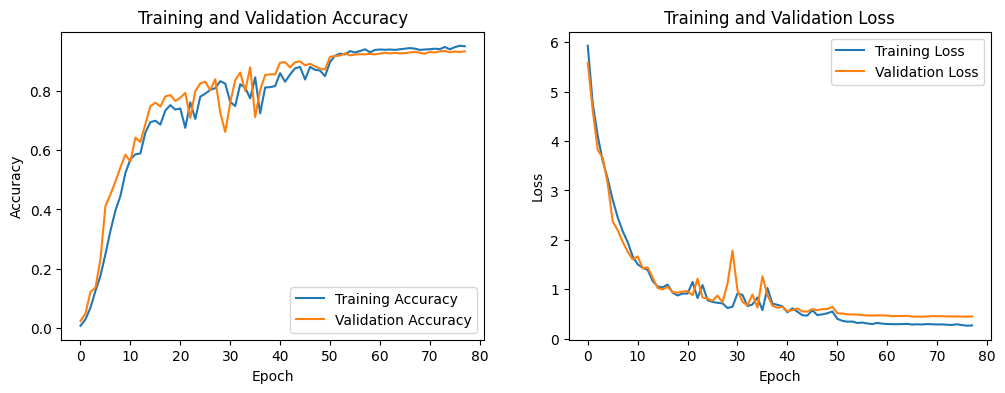

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_hybrid.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_hybrid.history['loss'], label='Training Loss')
plt.plot(history_model_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_hybrid2.png', format='png')

plt.show()

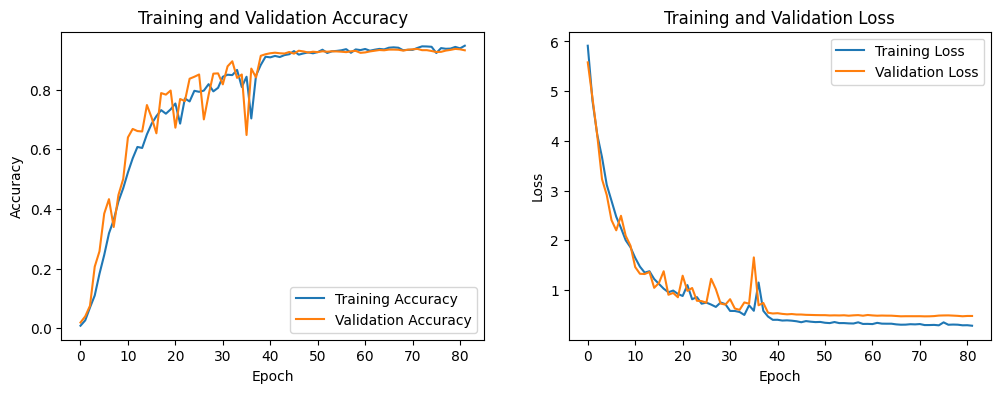

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_hybrid.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_hybrid.history['loss'], label='Training Loss')
plt.plot(history_model_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_hybrid.png', format='png')

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, 126)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(30, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    Dense(530, activation='softmax')
])

model_cnn_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_lstm.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            24256     
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 batch_normalization_12 (Ba  (None, 14, 64)            256       
 tchNormalization)                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                      

In [ ]:
history_model_cnn_lstm = model_cnn_lstm.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 12s 38ms/step - loss: 6.0029 - accuracy: 0.0094 - val_loss: 5.5795 - val_accuracy: 0.0057 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 3s 22ms/step - loss: 4.8455 - accuracy: 0.0208 - val_loss: 5.0611 - val_accuracy: 0.0222 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 3s 22ms/step - loss: 4.2849 - accuracy: 0.0507 - val_loss: 4.3164 - val_accuracy: 0.0679 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 4s 28ms/step - loss: 3.9304 - accuracy: 0.0715 - val_loss: 3.6232 - val_accuracy: 0.1401 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 4s 27ms/step - loss: 3.6384 - accuracy: 0.0990 - val_loss: 3.6716 - val_accuracy: 0.1165 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 3s 20ms/step - loss: 3.4107 - accuracy: 0.1270 - val_loss: 3.0697 - val_accuracy: 0.2363 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 3s

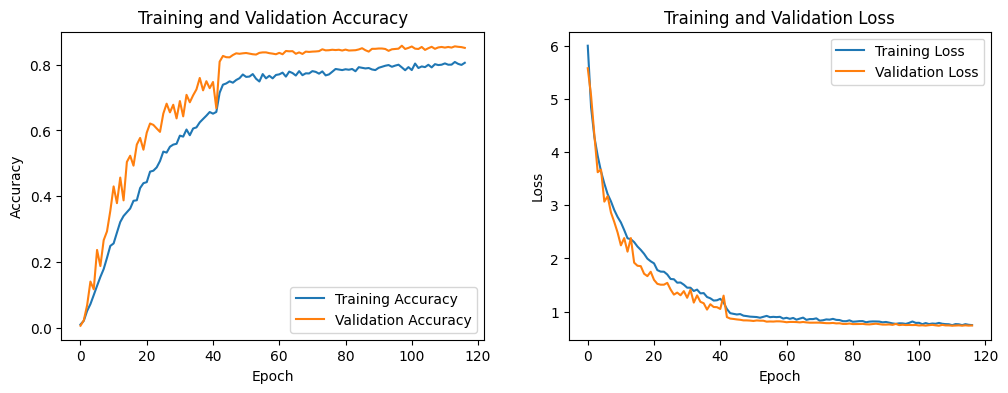

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_cnn_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_model_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_cnn_lstm.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_hybrid, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_hybrid, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_hybrid, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 14ms/step
Training Data - Accuracy: 0.9958071278825996, Precision: 0.9961229546135205, Recall: 0.9958071278825997, F1 Score: 0.9955556599681739
67/67 [==============================] - 1s 14ms/step
Validation Data - Accuracy: 0.9363207547169812, Precision: 0.9472574123989218, Recall: 0.9363207547169812, F1 Score: 0.9302341474039587
67/67 [==============================] - 1s 14ms/step
Test Data - Accuracy: 0.8764150943396226, Precision: 0.8956928448909581, Recall: 0.8764150943396226, F1 Score: 0.8630275803860711


In [ ]:
model_hybrid.save('/content/drive/MyDrive/model_hybrid.keras')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras_tuner import Hyperband

def build_model(hp):
    model = Sequential([
        Conv1D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
            activation='relu',
            input_shape=(30, 126)
        ),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(
            filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        LSTM(
            hp.Int('lstm1_units', min_value=30, max_value=70, step=10),
            return_sequences=True,
            kernel_regularizer=regularizers.l2(hp.Choice('lstm1_l2', values=[1e-4, 1e-5, 1e-6]))
        ),
        Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)),
        BatchNormalization(),
        LSTM(
            hp.Int('lstm2_units', min_value=20, max_value=50, step=10),
            kernel_regularizer=regularizers.l2(hp.Choice('lstm2_l2', values=[1e-4, 1e-5, 1e-6]))
        ),
        Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(
            hp.Int('dense_units', min_value=50, max_value=150, step=50),
            activation='relu',
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Choice('dense_l1', values=[1e-4, 1e-5, 1e-6]),
                l2=hp.Choice('dense_l2', values=[1e-4, 1e-5, 1e-6])
            )
        ),
        Dense(530, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Configure the Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='my_dir',
    project_name='hyperband_cnn_lstm'
)


Reloading Tuner from my_dir/hyperband_cnn_lstm/tuner0.json


In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start search
tuner.search(train_sequences_guided, train_labels_guided,
             epochs=50,
             validation_data=(val_sequences_guided, val_labels_guided),
             callbacks=[reduce_lr, early_stopping])

Trial 90 Complete [00h 04m 32s]
val_accuracy: 0.5382075309753418

Best val_accuracy So Far: 0.8481131792068481
Total elapsed time: 01h 31m 04s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print('Best hyperparameters:', best_hyperparameters.values)

Best hyperparameters: {'conv1_filters': 32, 'conv1_kernel_size': 5, 'conv2_filters': 128, 'conv2_kernel_size': 5, 'lstm1_units': 60, 'lstm1_l2': 1e-06, 'dropout1': 0.1, 'lstm2_units': 40, 'lstm2_l2': 0.0001, 'dropout2': 0.2, 'dense_units': 150, 'dense_l1': 1e-05, 'dense_l2': 0.0001, 'learning_rate': 0.000614026941621319, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0069'}


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 32)            20192     
                                                                 
 max_pooling1d (MaxPooling1  (None, 13, 32)            0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 32)            128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 128)            20608     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 128)            0         
 g1D)                                                            
                                                        

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten

model_cnn_lstm_tuned = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(30, 126)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(60, return_sequences=True, kernel_regularizer=regularizers.l2(1e-06)),
    Dropout(0.1),
    BatchNormalization(),
    LSTM(40, kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.2),
    Flatten(),
    Dense(150, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-05, l2=0.0001)),
    Dense(530, activation='softmax')
])

model_cnn_lstm_tuned.compile(
    optimizer=Adam(learning_rate=0.000614),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_cnn_lstm_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 26, 32)            20192     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 13, 32)            0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 13, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 128)            20608     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 4, 128)            0         
 g1D)                                                            
                                                      

In [ ]:
history_model_cnn_lstm_tuned = model_cnn_lstm_tuned.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 17s 39ms/step - loss: 6.0867 - accuracy: 0.0088 - val_loss: 5.8634 - val_accuracy: 0.0118 - lr: 6.1400e-04
Epoch 2/200
150/150 [==============================] - 3s 21ms/step - loss: 5.0385 - accuracy: 0.0178 - val_loss: 5.1367 - val_accuracy: 0.0250 - lr: 6.1400e-04
Epoch 3/200
150/150 [==============================] - 4s 25ms/step - loss: 4.3631 - accuracy: 0.0539 - val_loss: 4.3510 - val_accuracy: 0.0717 - lr: 6.1400e-04
Epoch 4/200
150/150 [==============================] - 3s 20ms/step - loss: 3.8606 - accuracy: 0.0937 - val_loss: 3.6870 - val_accuracy: 0.1175 - lr: 6.1400e-04
Epoch 5/200
150/150 [==============================] - 4s 30ms/step - loss: 3.4924 - accuracy: 0.1314 - val_loss: 3.2278 - val_accuracy: 0.2151 - lr: 6.1400e-04
Epoch 6/200
150/150 [==============================] - 3s 20ms/step - loss: 3.2117 - accuracy: 0.1660 - val_loss: 3.3486 - val_accuracy: 0.1901 - lr: 6.1400e-04
Epoch 7/200
150/150 [============

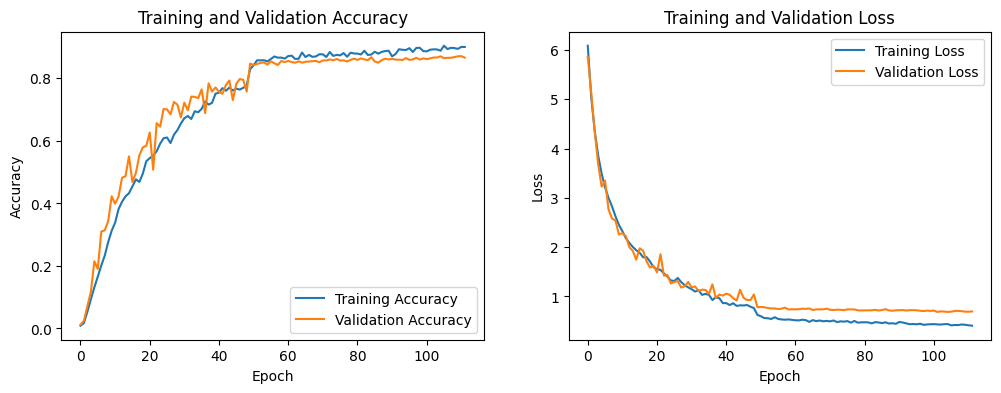

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_cnn_lstm_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_cnn_lstm_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_cnn_lstm_tuned.history['loss'], label='Training Loss')
plt.plot(history_model_cnn_lstm_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_cnn_lstm_tuned.png', format='png')

plt.show()

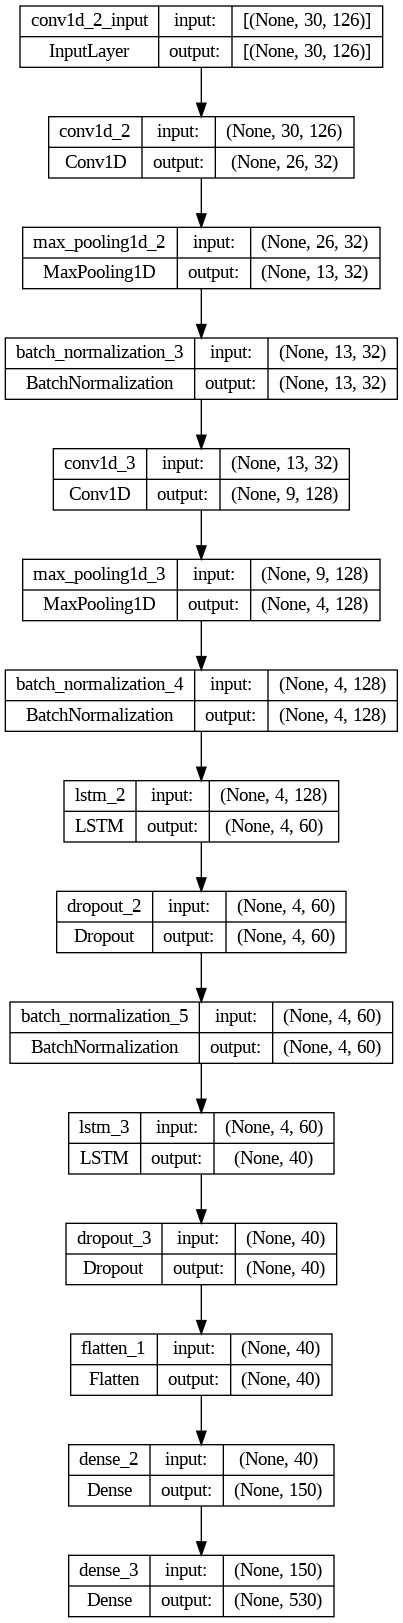

In [ ]:
from tensorflow.keras.utils import plot_model

# Define your model
model = model_cnn_lstm_tuned
# ... add your layers here ...

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

# Evaluate on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_cnn_lstm_tuned, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_cnn_lstm_tuned, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_cnn_lstm_tuned, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 10ms/step
Training Data - Accuracy: 0.9886792452830189, Precision: 0.9908587560238505, Recall: 0.9886792452830189, F1 Score: 0.9876972519243872
67/67 [==============================] - 1s 8ms/step
Validation Data - Accuracy: 0.8636792452830189, Precision: 0.8837683438155136, Recall: 0.8636792452830189, F1 Score: 0.8500278338014187
67/67 [==============================] - 1s 9ms/step
Test Data - Accuracy: 0.7948113207547169, Precision: 0.8262296822674181, Recall: 0.7948113207547169, F1 Score: 0.77424689566199


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Add, SpatialDropout1D
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=(30, 126))

# First convolutional block with adjustment to input for residual connection
x = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Adjust input_layer to have the same number of filters (32) using 1x1 convolution
input_adjusted = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(input_layer)

# Adding residual connection
x_res = Add()([x, input_adjusted])
x = MaxPooling1D(pool_size=2)(x_res)

# Second convolutional block
x = SpatialDropout1D(0.1)(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# LSTM layers
x = LSTM(60, return_sequences=True, kernel_regularizer=l2(1e-06))(x)
x = Dropout(0.2)(x)
x = LSTM(40, kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

# Flatten and dense layers
x = Flatten()(x)
x = Dense(150, activation='relu', kernel_regularizer=l1_l2(l1=1e-05, l2=0.0001))(x)

# Output layer
output_layer = Dense(530, activation='softmax')(x)

# Building the model
model_advanced = Model(inputs=input_layer, outputs=output_layer)
model_advanced.compile(optimizer=Adam(learning_rate=0.000614), loss='categorical_crossentropy', metrics=['accuracy'])

model_advanced.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 30, 126)]            0         []                            
                                                                                                  
 conv1d_14 (Conv1D)          (None, 30, 32)               20192     ['input_4[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 30, 32)               128       ['conv1d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_15 (Conv1D)          (None, 30, 128)              20608     ['batch_normalization_14

In [ ]:
history_model_advanced_2 = model_advanced.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 28s 83ms/step - loss: 5.9910 - accuracy: 0.0061 - val_loss: 5.8115 - val_accuracy: 0.0061 - lr: 6.1400e-04
Epoch 2/200
150/150 [==============================] - 9s 60ms/step - loss: 5.0906 - accuracy: 0.0122 - val_loss: 5.1002 - val_accuracy: 0.0151 - lr: 6.1400e-04
Epoch 3/200
150/150 [==============================] - 7s 45ms/step - loss: 4.5722 - accuracy: 0.0300 - val_loss: 5.1109 - val_accuracy: 0.0335 - lr: 6.1400e-04
Epoch 4/200
150/150 [==============================] - 9s 61ms/step - loss: 4.1684 - accuracy: 0.0539 - val_loss: 4.1449 - val_accuracy: 0.0637 - lr: 6.1400e-04
Epoch 5/200
150/150 [==============================] - 7s 45ms/step - loss: 3.8902 - accuracy: 0.0795 - val_loss: 3.6784 - val_accuracy: 0.1325 - lr: 6.1400e-04
Epoch 6/200
150/150 [==============================] - 8s 56ms/step - loss: 3.6242 - accuracy: 0.1042 - val_loss: 3.3925 - val_accuracy: 0.1745 - lr: 6.1400e-04
Epoch 7/200
150/150 [============

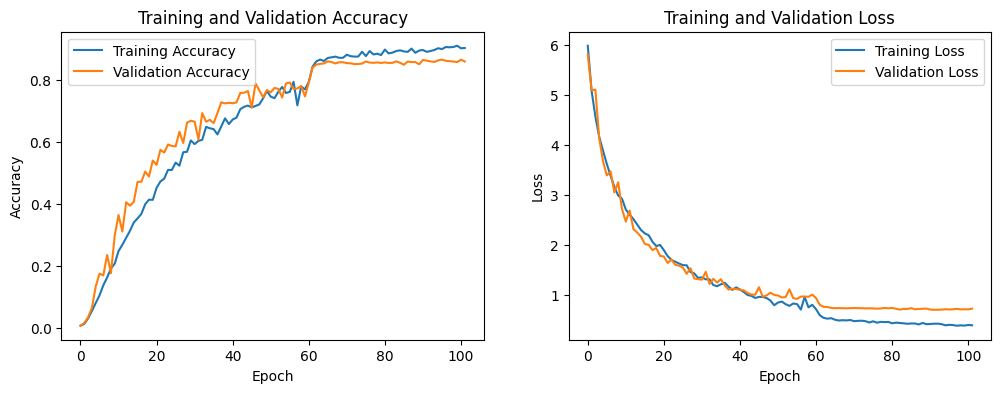

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_advanced_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_advanced_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_advanced_2.history['loss'], label='Training Loss')
plt.plot(history_model_advanced_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_advanced_2.png', format='png')

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Add, SpatialDropout1D
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=(30, 126))

# First convolutional block with adjustment to input for residual connection
x = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Adjust input_layer to have the same number of filters (32) using 1x1 convolution
input_adjusted = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(input_layer)

# Adding residual connection
x_res = Add()([x, input_adjusted])
x = MaxPooling1D(pool_size=2)(x_res)

# Second convolutional block
x = SpatialDropout1D(0.1)(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# LSTM layers
x = LSTM(70, return_sequences=True, kernel_regularizer=l2(1e-06))(x)
x = Dropout(0.2)(x)
x = LSTM(150, kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)

# Flatten and dense layers
x = Flatten()(x)
x = Dense(150, activation='relu', kernel_regularizer=l1_l2(l1=1e-05, l2=0.0001))(x)

# Output layer
output_layer = Dense(530, activation='softmax')(x)

# Building the model
model_advanced_2 = Model(inputs=input_layer, outputs=output_layer)
model_advanced_2.compile(optimizer=Adam(learning_rate=0.000614), loss='categorical_crossentropy', metrics=['accuracy'])

model_advanced_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30, 126)]            0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 30, 64)               40384     ['input_5[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 30, 64)               256       ['conv1d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_20 (Conv1D)          (None, 30, 128)              41088     ['batch_normalization_18

In [ ]:
history_model_advanced_3 = model_advanced_2.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 18s 77ms/step - loss: 5.8713 - accuracy: 0.0046 - val_loss: 5.3442 - val_accuracy: 0.0146 - lr: 6.1400e-04
Epoch 2/200
150/150 [==============================] - 8s 54ms/step - loss: 4.6844 - accuracy: 0.0321 - val_loss: 4.4118 - val_accuracy: 0.0443 - lr: 6.1400e-04
Epoch 3/200
150/150 [==============================] - 13s 86ms/step - loss: 4.0541 - accuracy: 0.0629 - val_loss: 3.7017 - val_accuracy: 0.1170 - lr: 6.1400e-04
Epoch 4/200
150/150 [==============================] - 11s 72ms/step - loss: 3.6703 - accuracy: 0.1006 - val_loss: 3.8141 - val_accuracy: 0.1137 - lr: 6.1400e-04
Epoch 5/200
150/150 [==============================] - 8s 56ms/step - loss: 3.2394 - accuracy: 0.1526 - val_loss: 3.5250 - val_accuracy: 0.1590 - lr: 6.1400e-04
Epoch 6/200
150/150 [==============================] - 10s 67ms/step - loss: 2.9483 - accuracy: 0.2015 - val_loss: 2.9167 - val_accuracy: 0.2420 - lr: 6.1400e-04
Epoch 7/200
150/150 [=========

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Add, SpatialDropout1D
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=(30, 126))

# First convolutional block with adjustment to input for residual connection
x = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Adjust input_layer to have the same number of filters (32) using 1x1 convolution
input_adjusted = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(input_layer)

# Adding residual connection
x_res = Add()([x, input_adjusted])
x = MaxPooling1D(pool_size=2)(x_res)

# Second convolutional block
x = SpatialDropout1D(0.1)(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# LSTM layers
x = LSTM(100, return_sequences=True, kernel_regularizer=l2(1e-06))(x)
x = Dropout(0.3)(x)
x = LSTM(180, kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)

# Flatten and dense layers
x = Flatten()(x)
x = Dense(150, activation='relu', kernel_regularizer=l1_l2(l1=1e-05, l2=0.0001))(x)

# Output layer
output_layer = Dense(530, activation='softmax')(x)

# Building the model
model_advanced_3 = Model(inputs=input_layer, outputs=output_layer)
model_advanced_3.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])

model_advanced_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30, 126)]            0         []                            
                                                                                                  
 conv1d_29 (Conv1D)          (None, 30, 64)               40384     ['input_7[0][0]']             
                                                                                                  
 batch_normalization_26 (Ba  (None, 30, 64)               256       ['conv1d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_30 (Conv1D)          (None, 30, 128)              41088     ['batch_normalization_26

In [ ]:
history_model_advanced_4 = model_advanced_3.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 20s 85ms/step - loss: 5.9280 - accuracy: 0.0075 - val_loss: 5.7852 - val_accuracy: 0.0042 - lr: 6.0000e-04
Epoch 2/200
150/150 [==============================] - 11s 77ms/step - loss: 4.5492 - accuracy: 0.0411 - val_loss: 6.0109 - val_accuracy: 0.0160 - lr: 6.0000e-04
Epoch 3/200
150/150 [==============================] - 10s 65ms/step - loss: 3.8806 - accuracy: 0.0774 - val_loss: 4.8154 - val_accuracy: 0.0491 - lr: 6.0000e-04
Epoch 4/200
150/150 [==============================] - 12s 79ms/step - loss: 3.4369 - accuracy: 0.1306 - val_loss: 3.4704 - val_accuracy: 0.1509 - lr: 6.0000e-04
Epoch 5/200
150/150 [==============================] - 15s 101ms/step - loss: 3.0888 - accuracy: 0.1734 - val_loss: 3.3884 - val_accuracy: 0.1915 - lr: 6.0000e-04
Epoch 6/200
150/150 [==============================] - 14s 96ms/step - loss: 2.7782 - accuracy: 0.2340 - val_loss: 2.7296 - val_accuracy: 0.2722 - lr: 6.0000e-04
Epoch 7/200
150/150 [======

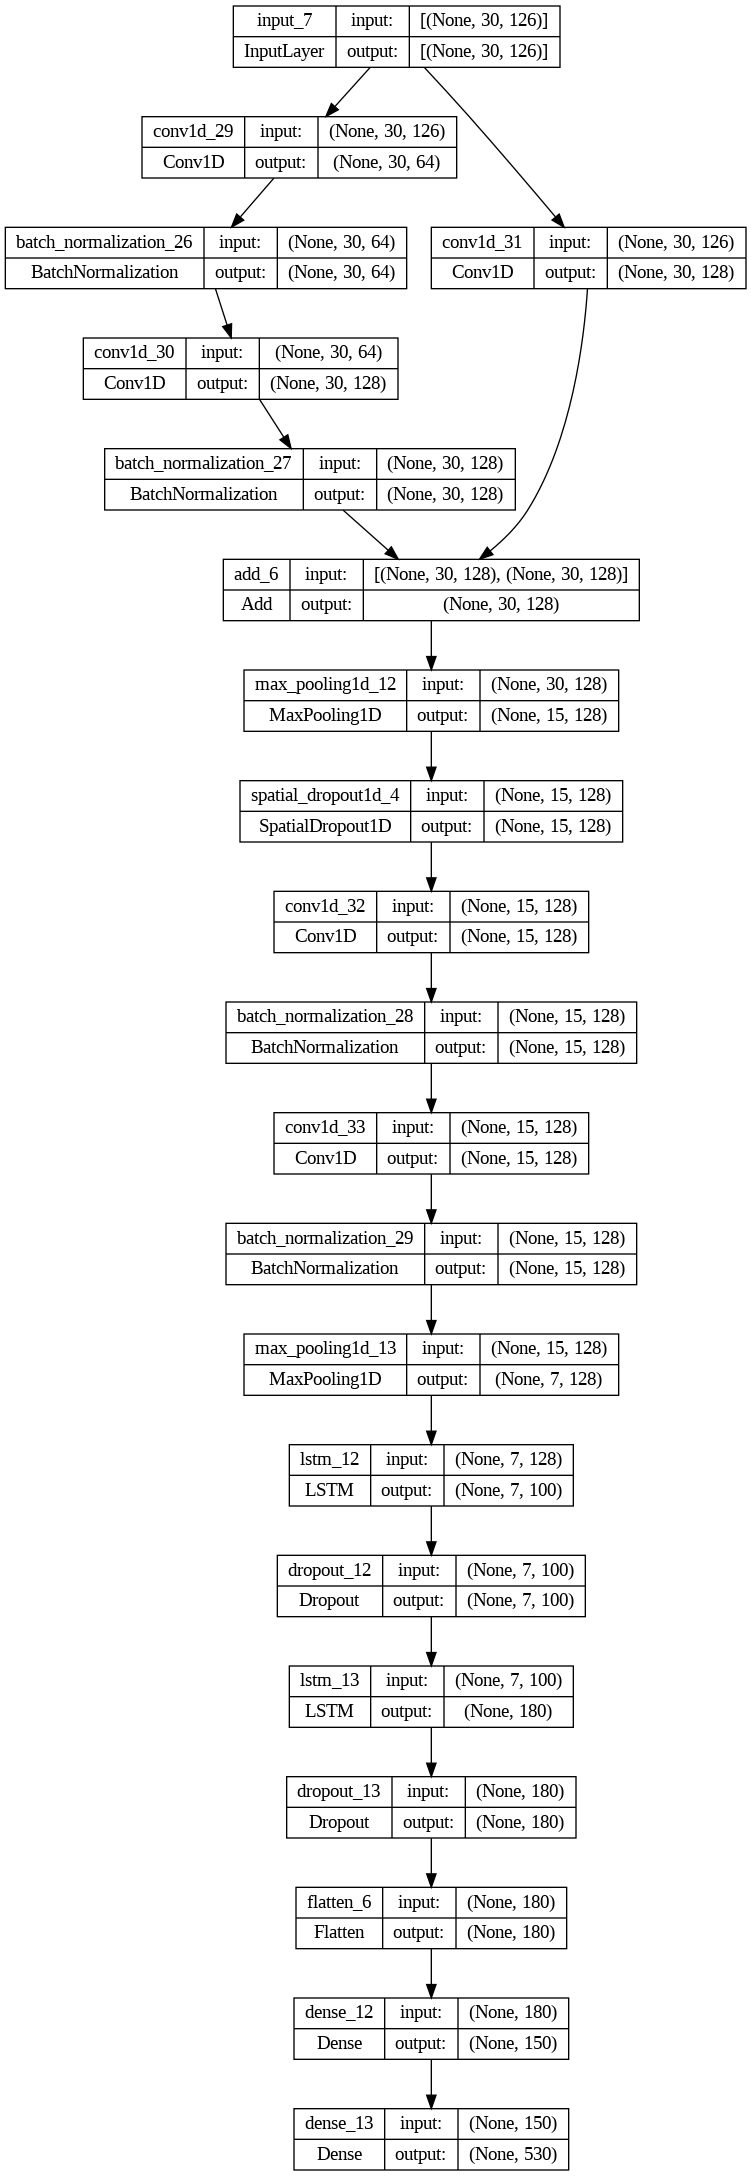

In [ ]:
# prompt: code to draw sequential model

from tensorflow.keras.utils import plot_model

# Define your model
model = model_advanced_3
# ... add your layers here ...

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)


#second correction

In [ ]:
from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_new_new_tuned = Sequential([
    LSTM(100, return_sequences=True, input_shape=(30, 126), kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    BatchNormalization(),
    LSTM(70, kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.2),  # Reduced dropout
    BatchNormalization(),
    Dense(100, activation='relu'),
    Dense(530, activation='softmax')
])

model_new_new_tuned.compile(optimizer=Adam(learning_rate=0.000603), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_new_new_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           90800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 batch_normalization (Batch  (None, 30, 100)           400       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 70)                47880     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 70)                280       
 chNormalization)                                       

In [ ]:
history_model_new_new_tuned = model_new_new_tuned.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 43s 185ms/step - loss: 5.9524 - accuracy: 0.0075 - val_loss: 5.7482 - val_accuracy: 0.0099 - lr: 6.0300e-04
Epoch 2/200
150/150 [==============================] - 20s 130ms/step - loss: 5.0226 - accuracy: 0.0270 - val_loss: 4.8063 - val_accuracy: 0.0443 - lr: 6.0300e-04
Epoch 3/200
150/150 [==============================] - 19s 127ms/step - loss: 4.4128 - accuracy: 0.0497 - val_loss: 4.2110 - val_accuracy: 0.0962 - lr: 6.0300e-04
Epoch 4/200
150/150 [==============================] - 12s 81ms/step - loss: 3.9118 - accuracy: 0.0891 - val_loss: 3.8877 - val_accuracy: 0.1127 - lr: 6.0300e-04
Epoch 5/200
150/150 [==============================] - 12s 80ms/step - loss: 3.4770 - accuracy: 0.1488 - val_loss: 3.2468 - val_accuracy: 0.2255 - lr: 6.0300e-04
Epoch 6/200
150/150 [==============================] - 12s 78ms/step - loss: 3.0063 - accuracy: 0.2335 - val_loss: 2.9685 - val_accuracy: 0.2458 - lr: 6.0300e-04
Epoch 7/200
150/150 [====

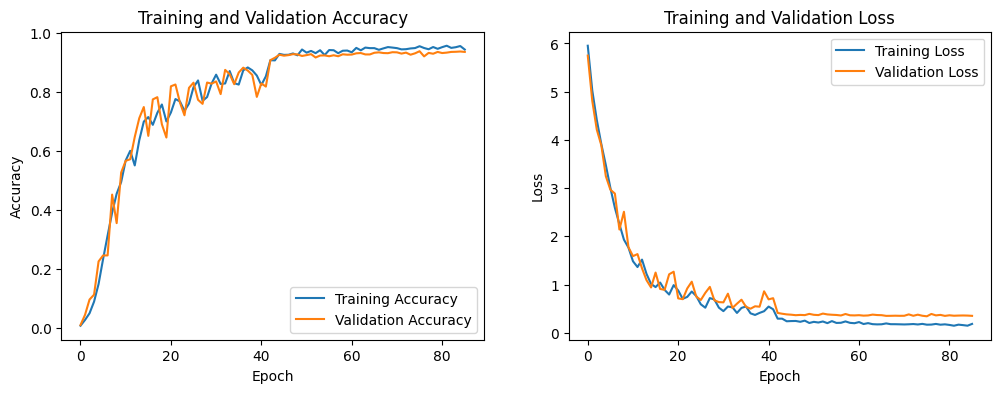

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model_new_new_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_new_new_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model_new_new_tuned.history['loss'], label='Training Loss')
plt.plot(history_model_new_new_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_model_new_new_tuned.png', format='png')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1


train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_new_new_tuned, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model_new_new_tuned, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_new_new_tuned, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 4s 20ms/step
Training Data - Accuracy: 0.9955974842767296, Precision: 0.9960886492961963, Recall: 0.9955974842767294, F1 Score: 0.9954827920004232
67/67 [==============================] - 1s 20ms/step
Validation Data - Accuracy: 0.9377358490566038, Precision: 0.9483198562443845, Recall: 0.9377358490566038, F1 Score: 0.9335111220016881
67/67 [==============================] - 1s 22ms/step
Test Data - Accuracy: 0.8712264150943396, Precision: 0.8997025511176454, Recall: 0.8712264150943396, F1 Score: 0.8567166900185769


In [ ]:
model_new_new_tuned.save('modelNafees.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_shape = (30, 126)
inputs = Input(shape=input_shape)

x = LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

x = LSTM(70, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = Dense(100, activation='relu')(x)
outputs = Dense(530, activation='softmax')(x)

attention_model = Model(inputs, outputs)

attention_model.compile(optimizer=Adam(learning_rate=0.000603), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 batch_normalization_2 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 attention (Attention)       (None, 100)               10200     
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 100)            0         
 )                                                           

In [ ]:
history_attention_model = attention_model.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 23s 88ms/step - loss: 5.8591 - accuracy: 0.0094 - val_loss: 6.1136 - val_accuracy: 0.0212 - lr: 6.0300e-04
Epoch 2/200
150/150 [==============================] - 8s 51ms/step - loss: 4.7479 - accuracy: 0.0396 - val_loss: 5.1555 - val_accuracy: 0.0816 - lr: 6.0300e-04
Epoch 3/200
150/150 [==============================] - 8s 53ms/step - loss: 3.9747 - accuracy: 0.1048 - val_loss: 4.0806 - val_accuracy: 0.1434 - lr: 6.0300e-04
Epoch 4/200
150/150 [==============================] - 9s 62ms/step - loss: 3.3296 - accuracy: 0.2071 - val_loss: 3.3280 - val_accuracy: 0.2000 - lr: 6.0300e-04
Epoch 5/200
150/150 [==============================] - 6s 43ms/step - loss: 2.6339 - accuracy: 0.3476 - val_loss: 3.1641 - val_accuracy: 0.1873 - lr: 6.0300e-04
Epoch 6/200
150/150 [==============================] - 9s 60ms/step - loss: 2.1165 - accuracy: 0.4497 - val_loss: 2.0798 - val_accuracy: 0.4547 - lr: 6.0300e-04
Epoch 7/200
150/150 [============

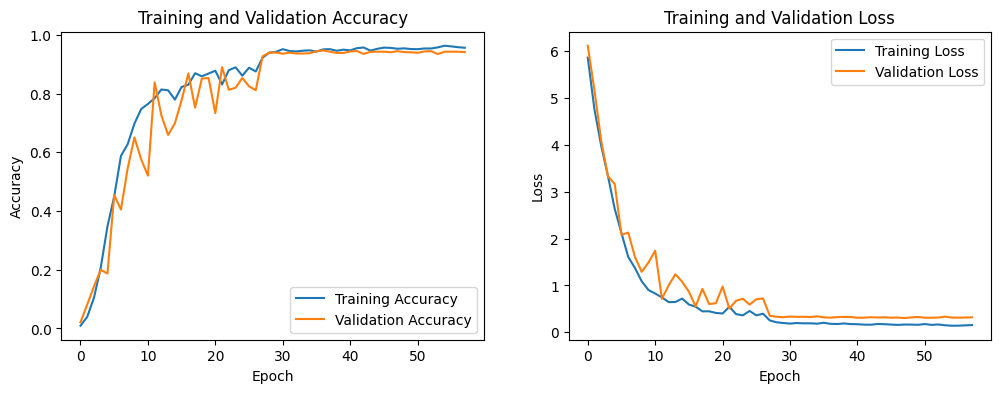

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_attention_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_attention_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_attention_model.history['loss'], label='Training Loss')
plt.plot(history_attention_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_attention_model.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(attention_model, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(attention_model, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(attention_model, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")

150/150 [==============================] - 6s 22ms/step
Training Data - Accuracy: 0.9947589098532494, Precision: 0.995394291243348, Recall: 0.9947589098532493, F1 Score: 0.9945662602347777
67/67 [==============================] - 1s 21ms/step
Validation Data - Accuracy: 0.944811320754717, Precision: 0.9580053908355795, Recall: 0.944811320754717, F1 Score: 0.9381287266192927
67/67 [==============================] - 1s 22ms/step
Test Data - Accuracy: 0.8853773584905661, Precision: 0.9091135070380354, Recall: 0.8853773584905661, F1 Score: 0.8720442869499474


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_shape = (30, 126)
inputs = Input(shape=input_shape)

x = LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

x = LSTM(70, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(530, activation='softmax')(x)

attention_model_2 = Model(inputs, outputs)

attention_model_2.compile(optimizer=Adam(learning_rate=0.000603), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

attention_model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout_4 (Dropout)         (None, 30, 100)           0         
                                                                 
 batch_normalization_4 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 attention_2 (Attention)     (None, 100)               10200     
                                                                 
 tf.expand_dims_1 (TFOpLamb  (None, 1, 100)            0         
 da)                                                       

In [ ]:
history_attention_model_2 = attention_model_2.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 33s 106ms/step - loss: 5.9650 - accuracy: 0.0065 - val_loss: 6.1242 - val_accuracy: 0.0217 - lr: 6.0300e-04
Epoch 2/200
150/150 [==============================] - 9s 57ms/step - loss: 4.9227 - accuracy: 0.0306 - val_loss: 5.2216 - val_accuracy: 0.0505 - lr: 6.0300e-04
Epoch 3/200
150/150 [==============================] - 9s 63ms/step - loss: 4.2611 - accuracy: 0.0602 - val_loss: 4.2860 - val_accuracy: 0.0906 - lr: 6.0300e-04
Epoch 4/200
150/150 [==============================] - 7s 46ms/step - loss: 3.7560 - accuracy: 0.1151 - val_loss: 3.5480 - val_accuracy: 0.2085 - lr: 6.0300e-04
Epoch 5/200
150/150 [==============================] - 9s 63ms/step - loss: 3.2419 - accuracy: 0.1895 - val_loss: 3.3220 - val_accuracy: 0.1873 - lr: 6.0300e-04
Epoch 6/200
150/150 [==============================] - 7s 46ms/step - loss: 2.7958 - accuracy: 0.2627 - val_loss: 2.8268 - val_accuracy: 0.2660 - lr: 6.0300e-04
Epoch 7/200
150/150 [===========

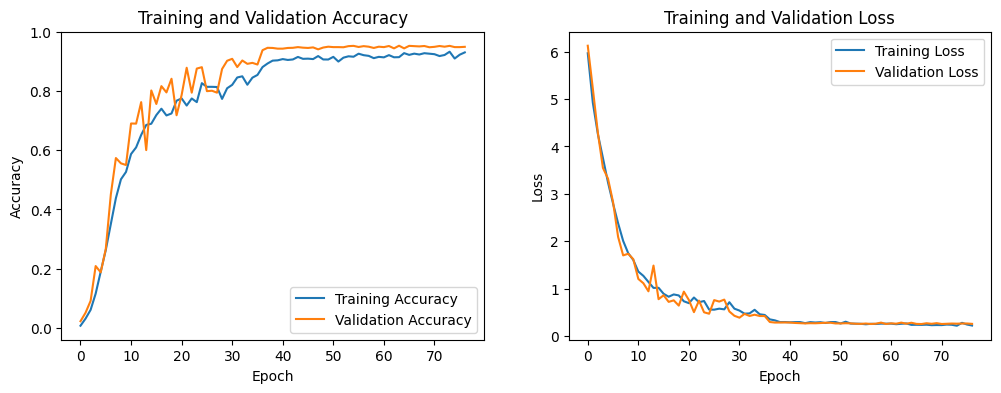

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_attention_model_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_attention_model_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_attention_model_2.history['loss'], label='Training Loss')
plt.plot(history_attention_model_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_attention_model_2.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(attention_model_2, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(attention_model_2, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(attention_model_2, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")

150/150 [==============================] - 5s 25ms/step
Training Data - Accuracy: 0.9935010482180293, Precision: 0.9941160935500557, Recall: 0.9935010482180293, F1 Score: 0.9932345547634306
67/67 [==============================] - 2s 27ms/step
Validation Data - Accuracy: 0.9528301886792453, Precision: 0.9628391734052112, Recall: 0.9528301886792453, F1 Score: 0.9473967332457899
67/67 [==============================] - 2s 30ms/step
Test Data - Accuracy: 0.8952830188679245, Precision: 0.917491764001198, Recall: 0.8952830188679245, F1 Score: 0.8827317965053815


In [ ]:
attention_model_2.save('/content/drive/MyDrive/attention_model_2.keras')

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_shape = (30, 126)
inputs = Input(shape=input_shape)

x = LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

x = LSTM(70, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(530, activation='softmax')(x)

attention_model_3 = Model(inputs, outputs)

attention_model_3.compile(optimizer=Adam(learning_rate=0.000603), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

attention_model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 100)           90800     
                                                                 
 dropout_7 (Dropout)         (None, 30, 100)           0         
                                                                 
 batch_normalization_6 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 attention_4 (Attention)     (None, 100)               10200     
                                                                 
 tf.expand_dims_2 (TFOpLamb  (None, 1, 100)            0         
 da)                                                       

In [ ]:
history_attention_model_3 = attention_model_3.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 21s 80ms/step - loss: 7.8364 - accuracy: 0.0044 - val_loss: 7.0081 - val_accuracy: 0.0094 - lr: 6.0300e-04
Epoch 2/200
150/150 [==============================] - 8s 51ms/step - loss: 5.7316 - accuracy: 0.0218 - val_loss: 5.9574 - val_accuracy: 0.0434 - lr: 6.0300e-04
Epoch 3/200
150/150 [==============================] - 8s 51ms/step - loss: 4.8972 - accuracy: 0.0392 - val_loss: 4.8900 - val_accuracy: 0.0741 - lr: 6.0300e-04
Epoch 4/200
150/150 [==============================] - 8s 53ms/step - loss: 4.4817 - accuracy: 0.0562 - val_loss: 4.5028 - val_accuracy: 0.0679 - lr: 6.0300e-04
Epoch 5/200
150/150 [==============================] - 7s 47ms/step - loss: 4.1025 - accuracy: 0.0872 - val_loss: 3.8063 - val_accuracy: 0.1415 - lr: 6.0300e-04
Epoch 6/200
150/150 [==============================] - 8s 57ms/step - loss: 3.8087 - accuracy: 0.1205 - val_loss: 3.5611 - val_accuracy: 0.1726 - lr: 6.0300e-04
Epoch 7/200
150/150 [============

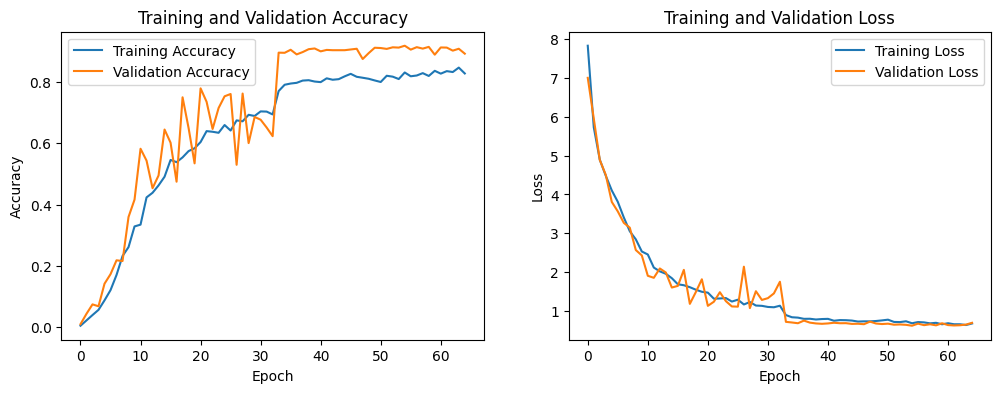

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_attention_model_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_attention_model_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_attention_model_3.history['loss'], label='Training Loss')
plt.plot(history_attention_model_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_attention_model_3.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(attention_model_3, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(attention_model_3, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(attention_model_3, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")

150/150 [==============================] - 5s 21ms/step
Training Data - Accuracy: 0.9796645702306079, Precision: 0.9818825566467076, Recall: 0.979664570230608, F1 Score: 0.9793770804942603
67/67 [==============================] - 2s 29ms/step
Validation Data - Accuracy: 0.9183962264150943, Precision: 0.9342849655585505, Recall: 0.9183962264150943, F1 Score: 0.909861071842204
67/67 [==============================] - 2s 32ms/step
Test Data - Accuracy: 0.855188679245283, Precision: 0.8859286939475618, Recall: 0.855188679245283, F1 Score: 0.8381656184486372


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def build_model(hp):
    input_shape = (30, 126)
    inputs = Input(shape=input_shape)

    # Hyperparameters
    lstm_units_1 = hp.Int('lstm_units_1', min_value=30, max_value=200, step=10)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=10, max_value=150, step=10)
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)
    dropout_rate_3 = hp.Float('dropout_rate_3', min_value=0.1, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=30, max_value=250, step=10)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')

    x = LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = Dropout(dropout_rate_1)(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

    x = LSTM(lstm_units_2, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate_2)(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate_3)(x)
    outputs = Dense(530, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

<ipython-input-27-69cc8826017c>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
import keras_tuner as kt

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='/content/drive/MyDrive/my_dir',
    project_name='attention_model_tuning'
)

# Define early stopping and reduce learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Run the tuner search
tuner.search(train_sequences_guided, train_labels_guided, validation_data=(val_sequences_guided, val_labels_guided),
             epochs=100, callbacks=[reduce_lr, early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')}.
The optimal number of units in the second LSTM layer is {best_hps.get('lstm_units_2')}.
The optimal dropout rate for the first LSTM layer is {best_hps.get('dropout_rate_1')}.
The optimal dropout rate for the second LSTM layer is {best_hps.get('dropout_rate_2')}.
The optimal dropout rate for the dense layer is {best_hps.get('dropout_rate_3')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal L2 regularization rate is {best_hps.get('l2_reg')}.
""")

Trial 254 Complete [00h 25m 20s]
val_loss: 0.5308536291122437

Best val_loss So Far: 0.23309770226478577
Total elapsed time: 10h 49m 23s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 180.
The optimal number of units in the second LSTM layer is 140.
The optimal dropout rate for the first LSTM layer is 0.5.
The optimal dropout rate for the second LSTM layer is 0.30000000000000004.
The optimal dropout rate for the dense layer is 0.1.
The optimal number of units in the dense layer is 170.
The optimal learning rate for the optimizer is 0.00045571813200880203.
The optimal L2 regularization rate is 4.3391778600941905e-06.



In [ ]:
# Rebuild the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 23s 114ms/step - loss: 5.9935 - accuracy: 0.0063 - val_loss: 6.1214 - val_accuracy: 0.0189 - lr: 4.5572e-04
Epoch 2/200
150/150 [==============================] - 16s 106ms/step - loss: 4.9871 - accuracy: 0.0275 - val_loss: 5.2400 - val_accuracy: 0.0660 - lr: 4.5572e-04
Epoch 3/200
150/150 [==============================] - 15s 101ms/step - loss: 4.3045 - accuracy: 0.0635 - val_loss: 4.2695 - val_accuracy: 0.0868 - lr: 4.5572e-04
Epoch 4/200
150/150 [==============================] - 15s 101ms/step - loss: 3.7368 - accuracy: 0.1254 - val_loss: 3.6680 - val_accuracy: 0.1542 - lr: 4.5572e-04
Epoch 5/200
150/150 [==============================] - 16s 107ms/step - loss: 3.1301 - accuracy: 0.2231 - val_loss: 2.7365 - val_accuracy: 0.3467 - lr: 4.5572e-04
Epoch 6/200
150/150 [==============================] - 16s 107ms/step - loss: 2.4856 - accuracy: 0.3499 - val_loss: 2.1806 - val_accuracy: 0.4726 - lr: 4.5572e-04
Epoch 7/200
150/150 [=

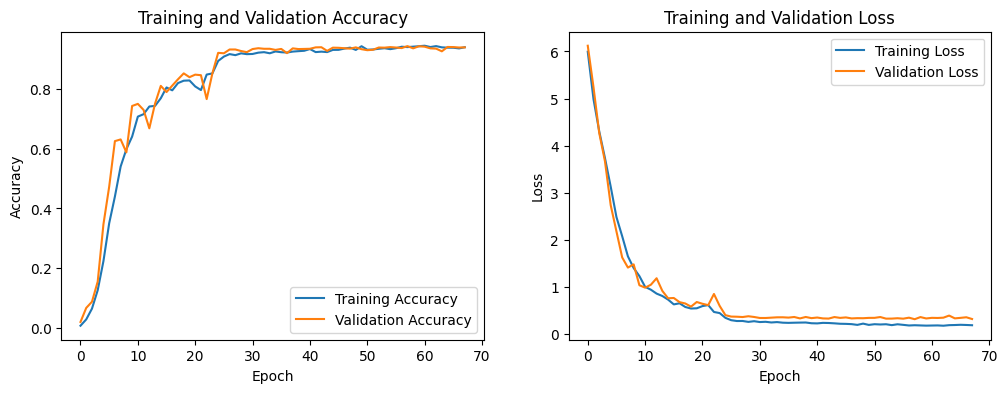

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history.png', format='png')

plt.show()

In [ ]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")

150/150 [==============================] - 9s 46ms/step
Training Data - Accuracy: 0.9926624737945493, Precision: 0.9940999802084707, Recall: 0.9926624737945492, F1 Score: 0.9921401484490157
67/67 [==============================] - 4s 58ms/step
Validation Data - Accuracy: 0.944811320754717, Precision: 0.955503144654088, Recall: 0.944811320754717, F1 Score: 0.9387700454681588
67/67 [==============================] - 3s 45ms/step
Test Data - Accuracy: 0.9014150943396226, Precision: 0.9258265947888589, Recall: 0.9014150943396226, F1 Score: 0.887969001648247


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 180)           221040    
                                                                 
 dropout_3 (Dropout)         (None, 30, 180)           0         
                                                                 
 batch_normalization_2 (Bat  (None, 30, 180)           720       
 chNormalization)                                                
                                                                 
 attention_2 (Attention)     (None, 180)               32760     
                                                                 
 tf.expand_dims_1 (TFOpLamb  (None, 1, 180)            0         
 da)                                                       

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

from tensorflow.keras.layers import Dropout, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_shape = (30, 126)
inputs = Input(shape=input_shape)

x = LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(5.0475e-05))(inputs)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

x = LSTM(60, return_sequences=True, kernel_regularizer=regularizers.l2(5.0475e-05))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Attention()(x)

x = Dense(230, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(530, activation='softmax')(x)

attention_model_tuned = Model(inputs, outputs)

attention_model_tuned.compile(optimizer=Adam(learning_rate=0.00069206), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

attention_model_tuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm (LSTM)                 (None, 30, 50)            35400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 batch_normalization (Batch  (None, 30, 50)            200       
 Normalization)                                                  
                                                                 
 attention (Attention)       (None, 50)                2600      
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 50)             0         
 )                                                           

In [ ]:
history_attention_model_tuned = attention_model_tuned.fit(
    train_sequences_guided, train_labels_guided,
    validation_data=(val_sequences_guided, val_labels_guided),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/200
150/150 [==============================] - 29s 93ms/step - loss: 5.6264 - accuracy: 0.0195 - val_loss: 6.0263 - val_accuracy: 0.0462 - lr: 6.9206e-04
Epoch 2/200
150/150 [==============================] - 11s 75ms/step - loss: 4.0669 - accuracy: 0.0948 - val_loss: 4.8204 - val_accuracy: 0.1571 - lr: 6.9206e-04
Epoch 3/200
150/150 [==============================] - 14s 92ms/step - loss: 2.9940 - accuracy: 0.2518 - val_loss: 3.2132 - val_accuracy: 0.3519 - lr: 6.9206e-04
Epoch 4/200
150/150 [==============================] - 12s 77ms/step - loss: 2.1024 - accuracy: 0.4501 - val_loss: 2.5660 - val_accuracy: 0.3547 - lr: 6.9206e-04
Epoch 5/200
150/150 [==============================] - 11s 71ms/step - loss: 1.5079 - accuracy: 0.5910 - val_loss: 1.3815 - val_accuracy: 0.6774 - lr: 6.9206e-04
Epoch 6/200
150/150 [==============================] - 12s 79ms/step - loss: 1.1525 - accuracy: 0.6836 - val_loss: 1.3681 - val_accuracy: 0.6231 - lr: 6.9206e-04
Epoch 7/200
150/150 [=======

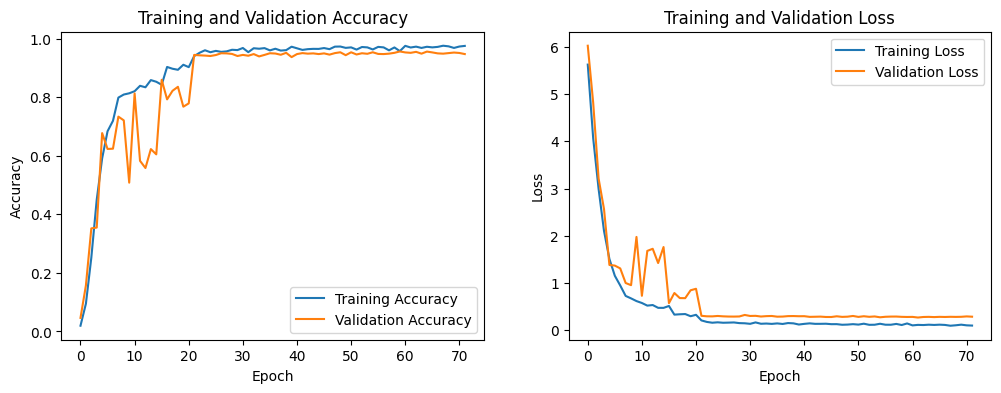

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_attention_model_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_attention_model_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_attention_model_tuned.history['loss'], label='Training Loss')
plt.plot(history_attention_model_tuned.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('my_graph_model_history_attention_model_tuned.png', format='png')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np

def evaluate_model(model, sequences, labels):
    # Making predictions
    predictions = model.predict(sequences)
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(labels, predictions, average='macro', zero_division=1)

    return accuracy, precision, recall, f1


train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(attention_model_tuned, train_sequences_guided, train_labels_guided)
print(f"Training Data - Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 Score: {train_f1}")

# Evaluate on validation data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(attention_model_tuned, val_sequences_guided, val_labels_guided)
print(f"Validation Data - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

# Evaluate on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(attention_model_tuned, test_sequences_guided, test_labels_guided)
print(f"Test Data - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


150/150 [==============================] - 3s 9ms/step
Training Data - Accuracy: 0.9960167714884696, Precision: 0.9963933236574748, Recall: 0.9960167714884697, F1 Score: 0.9959064850098204
67/67 [==============================] - 1s 10ms/step
Validation Data - Accuracy: 0.9514150943396227, Precision: 0.9626370170709793, Recall: 0.9514150943396227, F1 Score: 0.9468794413134037
67/67 [==============================] - 1s 9ms/step
Test Data - Accuracy: 0.8990566037735849, Precision: 0.9237002096436059, Recall: 0.8990566037735849, F1 Score: 0.8871276417502832


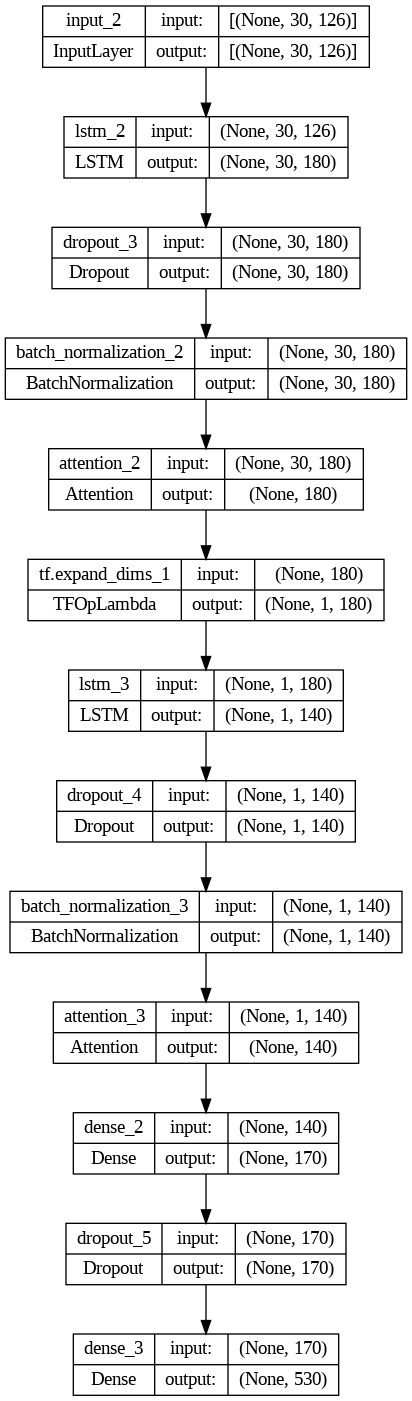

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.save('/content/drive/MyDrive/model_done.keras')

#Extras

In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.dot(score, self.u)
        attention_weights = K.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def build_model(hp):
    input_shape = (30, 126)
    inputs = Input(shape=input_shape)

    # Hyperparameters
    lstm_units_1 = hp.Int('lstm_units_1', min_value=30, max_value=200, step=10)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=10, max_value=150, step=10)
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)
    dropout_rate_3 = hp.Float('dropout_rate_3', min_value=0.1, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=30, max_value=250, step=10)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')

    x = LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = Dropout(dropout_rate_1)(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

    x = LSTM(lstm_units_2, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate_2)(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate_3)(x)
    outputs = Dense(530, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

<ipython-input-26-69cc8826017c>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
import keras_tuner as kt

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='/content/drive/MyDrive/my_dir',
    project_name='attention_model_tuning'
)

# Define early stopping and reduce learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Run the tuner search
tuner.search(train_sequences_guided, train_labels_guided, validation_data=(val_sequences_guided, val_labels_guided),
             epochs=100, callbacks=[reduce_lr, early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')}.
The optimal number of units in the second LSTM layer is {best_hps.get('lstm_units_2')}.
The optimal dropout rate for the first LSTM layer is {best_hps.get('dropout_rate_1')}.
The optimal dropout rate for the second LSTM layer is {best_hps.get('dropout_rate_2')}.
The optimal dropout rate for the dense layer is {best_hps.get('dropout_rate_3')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal L2 regularization rate is {best_hps.get('l2_reg')}.
""")

Reloading Tuner from /content/drive/MyDrive/my_dir/attention_model_tuning/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 180.
The optimal number of units in the second LSTM layer is 140.
The optimal dropout rate for the first LSTM layer is 0.5.
The optimal dropout rate for the second LSTM layer is 0.30000000000000004.
The optimal dropout rate for the dense layer is 0.1.
The optimal number of units in the dense layer is 170.
The optimal learning rate for the optimizer is 0.00045571813200880203.
The optimal L2 regularization rate is 4.3391778600941905e-06.



In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 126)]         0         
                                                                 
 lstm (LSTM)                 (None, 30, 180)           221040    
                                                                 
 dropout (Dropout)           (None, 30, 180)           0         
                                                                 
 batch_normalization (Batch  (None, 30, 180)           720       
 Normalization)                                                  
                                                                 
 attention (Attention)       (None, 180)               32760     
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 180)            0         
 )                                                           

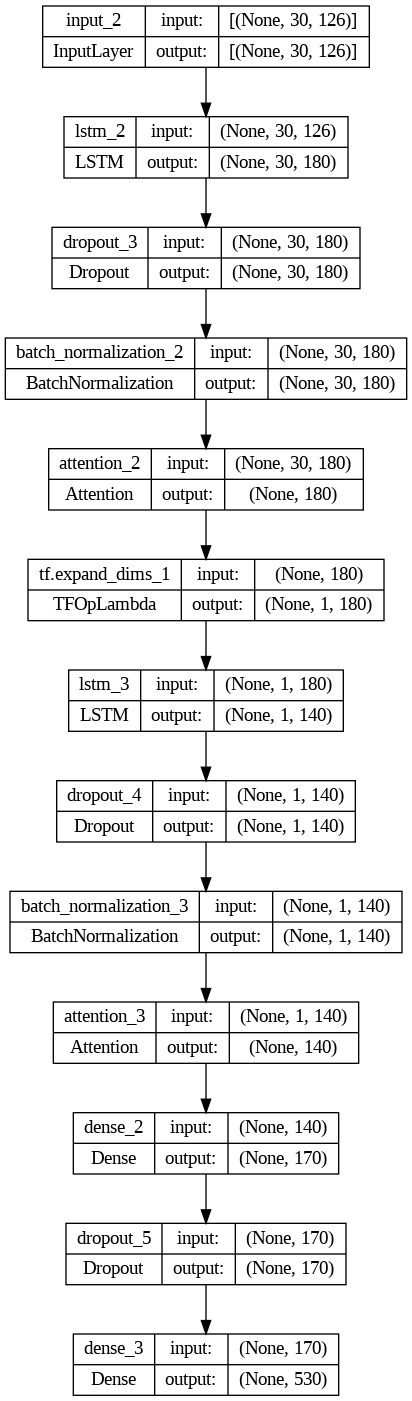

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_score', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=[2, 0]) + self.b)
        score = tf.tensordot(score, self.u, axes=[2, 0])
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Define the best hyperparameters found
best_hps = {
    'lstm_units_1': 180,
    'lstm_units_2': 140,
    'dropout_rate_1': 0.5,
    'dropout_rate_2': 0.3,
    'dropout_rate_3': 0.1,
    'dense_units': 170,
    'learning_rate': 0.00045571813200880203,
    'l2_reg': 4.3391778600941905e-06
}

# Build the model using the best hyperparameters
def build_model_with_best_hps():
    input_shape = (30, 126)
    inputs = Input(shape=input_shape)

    x = LSTM(best_hps['lstm_units_1'], return_sequences=True, kernel_regularizer=l2(best_hps['l2_reg']))(inputs)
    x = Dropout(best_hps['dropout_rate_1'])(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = tf.expand_dims(x, axis=1)  # Expand dimensions to fit the next LSTM layer

    x = LSTM(best_hps['lstm_units_2'], return_sequences=True, kernel_regularizer=l2(best_hps['l2_reg']))(x)
    x = Dropout(best_hps['dropout_rate_2'])(x)
    x = BatchNormalization()(x)
    x = Attention()(x)

    x = Dense(best_hps['dense_units'], activation='relu')(x)
    x = Dropout(best_hps['dropout_rate_3'])(x)
    outputs = Dense(530, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=best_hps['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model
model = build_model_with_best_hps()

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (if using a Jupyter Notebook)
from IPython.display import Image
Image(filename='model_architecture.png')
